In [2]:
#install tensorflow federated
!pip install -U flwr["simulation"] tensorflow_privacy tensorflow_federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/

In [2]:
#imports and load data from sql server
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow_federated as tff
import tensorflow_privacy
from datetime import datetime
from time import time
import collections
import tensorflow as tf
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasSGDOptimizer
import numpy as np
from typing import Any, Callable, Dict, List, Optional, Tuple
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


import flwr as fl
from flwr.common import EvaluateIns, NDArrays, Parameters, Scalar, Metrics
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

# Enable GPU growth
enable_tf_gpu_growth()
tff.simulation.datasets.emnist.load_data(only_digits=True)

(<tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData at 0x7f4098328250>,
 <tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData at 0x7f40581c8460>)

In [1]:
#HyperParameters

NUM_CLIENTS = 100
BATCH_SIZE = 8
MICROBATCH_NUM = 4
EPOCHS = 5
ROUNDS = 50

SGD_LEARNING_RATE = .1
SGD_NOISE = .2
L2_NORM_CLIP = 1

In [4]:
#class defining individual flower client
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_val, y_val, cid) -> None:

        optimizer =  VectorizedDPKerasSGDOptimizer(
                              l2_norm_clip=L2_NORM_CLIP,
                              noise_multiplier=SGD_NOISE,
                              num_microbatches=MICROBATCH_NUM,
                              learning_rate=SGD_LEARNING_RATE)

        loss = tf.keras.losses.CategoricalCrossentropy(
                              from_logits=True,
                              reduction=tf.losses.Reduction.NONE)

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

        self.model = model
        self.x_train, self.y_train, self.x_val, self.y_val = x_train, y_train, x_val, y_val
        self.x_test, self.y_test = x_test, y_test
        self.cid = cid

    def get_parameters(self,config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        previous_loss, _ = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        hist = self.model.fit(self.x_train, self.y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
        current_loss = hist.history['loss'][0]
        k_param = previous_loss / current_loss

        return self.model.get_weights(), len(self.x_train), {"metrics": k_param}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)

        loss, accuracy = self.model.evaluate(self.x_val, self.y_val, verbose=2)

        f = open("client_logs.txt", "a")
        time = datetime.now().time()
        f.write(str(time) + " " + self.cid + " " + str(len(self.x_train)) + " " + str(loss) + " " + str(accuracy) + "\n")
        f.close()

        return loss, len(self.x_val), {"accuracy": accuracy, "loss": loss}

In [5]:
#data processing
@tf.autograph.experimental.do_not_convert
def preprocess(dataset, batch_size):

  def batch_format_fn(element):
    # Flatten a batch 'pixels'
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28,28]),
        y=tf.reshape(element['label'], [-1, 1]))

    # Shuffle data for 100 clients and prefetch 10
  return dataset.shuffle(100, seed=1).batch(
      batch_size).map(batch_format_fn).prefetch(10)

In [6]:
#load in specific partition of dataset based on client id
def load_partition(idx: int):

    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)
    client_train = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[idx])
    client_test = emnist_test.create_tf_dataset_for_client(emnist_test.client_ids[idx])

    processed_train = preprocess(client_train, len(list(client_train)))
    processed_test = preprocess(client_test, len(list(client_test)))

    sample_train = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(processed_train)))

    sample_test = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(processed_test)))

    x_train = sample_train['x']
    y_train = sample_train['y']

    x_test = sample_test['x']
    y_test = sample_test['y']

    #Reshape to proper dimensions
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

    # If number of overall training samples not evenly divided by batch size.
    # Because every batch needs to be evenly divided by Microbatch_Num
    if x_train.shape[0] % BATCH_SIZE != 0:
      drop_num = x_train.shape[0] % BATCH_SIZE
      x_train = x_train[:-drop_num]
      y_train = y_train[:-drop_num]

    if x_train.shape[0] % BATCH_SIZE != 0:
        raise ValueError("Batch Size should divide total train samples")

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


    y_train = np.array(y_train, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.int32)

    # Hot Encoding of data
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

    return (x_train,y_train),(x_test,y_test)

In [7]:
#CNN Model for Client and Server

def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [8]:
# Get FlowerClient Model and Batched Data
def client_fn(cid: str) -> fl.client.Client:
    model = create_cnn_model()
    (x_train, y_train), (x_val, y_val) = load_partition(int(cid))
    return FlowerClient(model, x_train, y_train, x_val, y_val, cid)

In [9]:
#server-side evaluation
def get_eval_fn(model):

    x_vals = np.empty((0,28,28,1))
    y_vals = np.empty((0,10))

    for i in range(NUM_CLIENTS):
        emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)
        client_test = emnist_test.create_tf_dataset_for_client(emnist_train.client_ids[i])

        processed_client_test = preprocess(client_test, len(list(client_test)))
        sample_test = tf.nest.map_structure(lambda x: x.numpy(),
                                         next(iter(processed_client_test)))
        x = sample_test['x']
        x = x.reshape(x.shape[0], 28, 28, 1)

        y = np.array(sample_test['y'], dtype=np.int32)
        y = tf.keras.utils.to_categorical(y, num_classes=10)

        _ , x_test, _, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

        x_vals = np.append(x_vals, x_test, axis=0)
        y_vals = np.append(y_vals, y_test, axis=0)

    def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, fl.common.Scalar]):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_vals, y_vals)
        num_examples = len(x_vals)

        print('\nserver accuracy ' + str(accuracy))
        print('server loss ' + str(loss) + "\n")

        f = open("server_logs.txt", "a")
        time = datetime.now().time()
        f.write(str(time) + " " + str(num_examples) + " " + str(loss) + " " + str(accuracy)+ "\n")
        f.close()

        return loss, {"accuracy": accuracy, "loss": loss}

    return evaluate

In [11]:
accuray_var_list = []
loss_var_list = []

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy_variance = np.var(np.array([m["accuracy"] for _, m in metrics]))
    # Calculate variance for losses
    loss_variance = np.var(np.array([m["loss"] for _, m in metrics]))

    accuray_var_list.append(accuracy_variance)
    loss_var_list.append(loss_variance)

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples), "loss": sum(losses) / sum(examples)}

In [18]:
class custom_QFedAvg(fl.server.strategy.QFedAvg):
  def configure_evaluate(
   self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
    """Configure the next round of evaluation."""

    # Parameters and config
    config = {}
    if self.on_evaluate_config_fn is not None:
        # Custom evaluation config function provided
        config = self.on_evaluate_config_fn(server_round)
    evaluate_ins = EvaluateIns(parameters, config)

    # Sample clients
    if server_round >= 0:
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
    else:
        clients = list(client_manager.all().values())

    # Return client/config pairs
    return [(client, evaluate_ins) for client in clients]

In [19]:
Q_PARAM=0.001

In [20]:
model = create_cnn_model()
accuray_var_list = []
loss_var_list = []

model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Create QFedAvg strategy
strategy=custom_QFedAvg(
        q_param = Q_PARAM,
        qffl_learning_rate = .1,
        fraction_fit=0.1,                               # Sample 10% Clients for training
        fraction_evaluate=0.1,                          # Sample 10% Clients for Validation
        min_fit_clients=10,                             # Makesure atleast 10 clients available for training
        min_evaluate_clients=10,                        # Makesure atleast 10 clients available for training
        min_available_clients=int(NUM_CLIENTS * 0.75),  # Wait until 75 clients are free
        evaluate_metrics_aggregation_fn=weighted_average,
        evaluate_fn=get_eval_fn(model))

# Start simulation
start_time = time()

client_resources = {"num_cpus": 1, "num_gpus": 1.0}

history =fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },)

end_time = time()

print("wall clock time was: " + str(end_time-start_time))

(DefaultActor pid=90692) 11/11 - 2s - loss: 2.2869 - accuracy: 0.1023 - 2s/epoch - 175ms/step
(DefaultActor pid=90692) Epoch 2/5
(DefaultActor pid=90692) 11/11 - 0s - loss: 2.2853 - accuracy: 0.1364 - 37ms/epoch - 3ms/step
(DefaultActor pid=90692) Epoch 3/5
(DefaultActor pid=90692) 11/11 - 0s - loss: 2.2606 - accuracy: 0.1818 - 36ms/epoch - 3ms/step
(DefaultActor pid=90692) Epoch 4/5
(DefaultActor pid=90692) 11/11 - 0s - loss: 2.2590 - accuracy: 0.1932 - 37ms/epoch - 3ms/step
(DefaultActor pid=90692) Epoch 5/5
(DefaultActor pid=90692) 11/11 - 0s - loss: 2.2427 - accuracy: 0.1477 - 37ms/epoch - 3ms/step
(DefaultActor pid=90692) 1/1 - 0s - loss: 2.1928 - accuracy: 0.6000 - 212ms/epoch - 212ms/step
(DefaultActor pid=90692) Epoch 1/5
(DefaultActor pid=90692) 9/9 - 2s - loss: 2.2523 - accuracy: 0.2500 - 2s/epoch - 208ms/step
(DefaultActor pid=90692) Epoch 2/5
(DefaultActor pid=90692) 9/9 - 0s - loss: 2.2336 - accuracy: 0.1667 - 31ms/epoch - 3ms/step
(DefaultActor pid=90692) Epoch 3/5
(Defau

INFO flwr 2023-11-29 05:31:11,325 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-11-29 05:31:14,950	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 05:31:16,305 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 16256507904.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 32513015808.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 16256507904.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 32513015808.0}
INFO flwr 2023-11-29 05:31:16,307 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations

19/19 [==============================] - 0s 3ms/step - loss: 2.3031 - accuracy: 0.1119


INFO flwr 2023-11-29 05:31:23,521 | server.py:94 | initial parameters (loss, other metrics): 2.303074598312378, {'accuracy': 0.11185308545827866, 'loss': 2.303074598312378}
INFO:flwr:initial parameters (loss, other metrics): 2.303074598312378, {'accuracy': 0.11185308545827866, 'loss': 2.303074598312378}
INFO flwr 2023-11-29 05:31:23,523 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-29 05:31:23,529 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 100)



server accuracy 0.11185308545827866
server loss 2.303074598312378



(DefaultActor pid=106419) /usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
(DefaultActor pid=106419)   output, from_logits = _get_logits(


(DefaultActor pid=106419) 1/1 - 2s - loss: 2.3223 - accuracy: 0.0000e+00 - 2s/epoch - 2s/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 3s - loss: 2.3083 - accuracy: 0.1458 - 3s/epoch - 220ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.3017 - accuracy: 0.1458 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2930 - accuracy: 0.0833 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2755 - accuracy: 0.1667 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2749 - accuracy: 0.1771 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3042 - accuracy: 0.1429 - 235ms/epoch - 235ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 2.3219 - accuracy: 0.1250 - 2s/epoch - 144ms/step
(DefaultActor pid=106419

(DefaultActor pid=106419) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7c860adb69e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=106419) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7c860adb69e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.functio

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2960 - accuracy: 0.1429 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 2.3303 - accuracy: 0.1058 - 2s/epoch - 141ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.3245 - accuracy: 0.1058 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.3136 - accuracy: 0.0962 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2912 - accuracy: 0.1154 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2870 - accuracy: 0.0769 - 40ms/epoch - 3ms/step


(DefaultActor pid=106419) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7c8619507c70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=106419) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7c8619507c70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.functio

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2350 - accuracy: 0.2857 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 14/14 - 2s - loss: 2.3161 - accuracy: 0.1250 - 2s/epoch - 127ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.2941 - accuracy: 0.1250 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.2771 - accuracy: 0.1786 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.2591 - accuracy: 0.1786 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.2527 - accuracy: 0.2054 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3284 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 2.3225 - accuracy: 0.0682 - 2s/epoch - 162ms/step
(DefaultActor pid=1064

DEBUG flwr 2023-11-29 05:31:51,457 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 2.3153 - accuracy: 0.1250 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.3063 - accuracy: 0.1146 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2957 - accuracy: 0.0833 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2808 - accuracy: 0.1250 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 2.3031 - accuracy: 0.1119


WARNING flwr 2023-11-29 05:31:51,604 | qfedavg.py:225 | No fit_metrics_aggregation_fn provided



server accuracy 0.11185308545827866
server loss 2.303074598312378

19/19 [==============================] - 0s 2ms/step - loss: 2.2922 - accuracy: 0.1336


INFO flwr 2023-11-29 05:31:51,715 | server.py:125 | fit progress: (1, 2.292220115661621, {'accuracy': 0.13355593383312225, 'loss': 2.292220115661621}, 28.190781975999926)
INFO:flwr:fit progress: (1, 2.292220115661621, {'accuracy': 0.13355593383312225, 'loss': 2.292220115661621}, 28.190781975999926)
DEBUG flwr 2023-11-29 05:31:51,717 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 100)



server accuracy 0.13355593383312225
server loss 2.292220115661621

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2852 - accuracy: 0.0000e+00 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3216 - accuracy: 0.0000e+00 - 248ms/epoch - 248ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3030 - accuracy: 0.0000e+00 - 241ms/epoch - 241ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2554 - accuracy: 0.0000e+00 - 192ms/epoch - 192ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2845 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3169 - accuracy: 0.0000e+00 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3214 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3104 - accuracy: 0.0000e+00 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2652 - accuracy: 0.1667 - 210ms/epoch - 210ms/step


DEBUG flwr 2023-11-29 05:31:57,094 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:31:57,100 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3379 - accuracy: 0.0000e+00 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3501 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 2.3236 - accuracy: 0.1136 - 2s/epoch - 161ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2868 - accuracy: 0.1250 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2751 - accuracy: 0.1591 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2596 - accuracy: 0.1818 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2580 - accuracy: 0.1705 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2821 - accuracy: 0.1667 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor

DEBUG flwr 2023-11-29 05:32:22,548 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 2.2767 - accuracy: 0.2222 - 2s/epoch - 194ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2668 - accuracy: 0.1806 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2481 - accuracy: 0.1806 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2399 - accuracy: 0.2361 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2308 - accuracy: 0.1806 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.2922 - accuracy: 0.1336

server accuracy 0.13355593383312225
server loss 2.292220115661621

19/19 [==============================] - 0s 2ms/step - loss: 2.2849 - accuracy: 0.1886


INFO flwr 2023-11-29 05:32:22,797 | server.py:125 | fit progress: (2, 2.284872055053711, {'accuracy': 0.18864774703979492, 'loss': 2.284872055053711}, 59.272993872999905)
INFO:flwr:fit progress: (2, 2.284872055053711, {'accuracy': 0.18864774703979492, 'loss': 2.284872055053711}, 59.272993872999905)
DEBUG flwr 2023-11-29 05:32:22,800 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 100)



server accuracy 0.18864774703979492
server loss 2.284872055053711

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2725 - accuracy: 0.3333 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2945 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3179 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2508 - accuracy: 0.1667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2634 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3121 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3039 - accuracy: 0.1667 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2542 - accuracy: 0.0000e+00 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3008 - accuracy: 0.1429 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-11-29 05:32:27,590 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:32:27,595 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2393 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2781 - accuracy: 0.2000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 10/10 - 2s - loss: 2.3008 - accuracy: 0.1250 - 2s/epoch - 181ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2894 - accuracy: 0.2625 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2700 - accuracy: 0.1500 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2602 - accuracy: 0.2375 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2346 - accuracy: 0.1875 - 31ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2391 - accuracy: 0.2000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid

DEBUG flwr 2023-11-29 05:32:53,169 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


(DefaultActor pid=106419) 10/10 - 2s - loss: 2.3095 - accuracy: 0.1250 - 2s/epoch - 177ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2836 - accuracy: 0.1500 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2713 - accuracy: 0.1625 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 2.2564 - accuracy: 0.1875 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 2.2849 - accuracy: 0.1886

server accuracy 0.18864774703979492
server loss 2.284872055053711

19/19 [==============================] - 0s 2ms/step - loss: 2.2766 - accuracy: 0.2003


INFO flwr 2023-11-29 05:32:53,413 | server.py:125 | fit progress: (3, 2.2765603065490723, {'accuracy': 0.20033389329910278, 'loss': 2.2765603065490723}, 89.88814804899994)
INFO:flwr:fit progress: (3, 2.2765603065490723, {'accuracy': 0.20033389329910278, 'loss': 2.2765603065490723}, 89.88814804899994)
DEBUG flwr 2023-11-29 05:32:53,414 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 100)



server accuracy 0.20033389329910278
server loss 2.2765603065490723

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2654 - accuracy: 0.4000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2921 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2921 - accuracy: 0.2000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2914 - accuracy: 0.2500 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2542 - accuracy: 0.2857 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2544 - accuracy: 0.5000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2535 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2970 - accuracy: 0.1667 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2973 - accuracy: 0.0000e+00 - 252ms/epoch - 252ms/step


DEBUG flwr 2023-11-29 05:32:58,349 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:32:58,355 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3118 - accuracy: 0.2000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2760 - accuracy: 0.1667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 2.2796 - accuracy: 0.1477 - 2s/epoch - 167ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2355 - accuracy: 0.2841 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2267 - accuracy: 0.1932 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.2119 - accuracy: 0.2841 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.1889 - accuracy: 0.1705 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2819 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:33:24,347 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 2.2885 - accuracy: 0.1146 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2951 - accuracy: 0.1771 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2657 - accuracy: 0.1250 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2453 - accuracy: 0.2396 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2233 - accuracy: 0.2292 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2766 - accuracy: 0.2003

server accuracy 0.20033389329910278
server loss 2.2765603065490723

19/19 [==============================] - 0s 3ms/step - loss: 2.2657 - accuracy: 0.2204


INFO flwr 2023-11-29 05:33:24,598 | server.py:125 | fit progress: (4, 2.2657439708709717, {'accuracy': 0.22036728262901306, 'loss': 2.2657439708709717}, 121.07381073199986)
INFO:flwr:fit progress: (4, 2.2657439708709717, {'accuracy': 0.22036728262901306, 'loss': 2.2657439708709717}, 121.07381073199986)
DEBUG flwr 2023-11-29 05:33:24,600 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 100)



server accuracy 0.22036728262901306
server loss 2.2657439708709717

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1976 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2298 - accuracy: 0.5000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2721 - accuracy: 0.1667 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3059 - accuracy: 0.2500 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3215 - accuracy: 0.0000e+00 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2497 - accuracy: 0.0000e+00 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2260 - accuracy: 0.5000 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3005 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2308 - accuracy: 0.4000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:33:29,453 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:33:29,459 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2943 - accuracy: 0.2000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3564 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 2.2761 - accuracy: 0.1458 - 2s/epoch - 148ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2605 - accuracy: 0.1667 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2665 - accuracy: 0.1771 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2450 - accuracy: 0.2083 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 2.2120 - accuracy: 0.2604 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2863 - accuracy: 0.1667 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid

DEBUG flwr 2023-11-29 05:33:55,671 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 2.2873 - accuracy: 0.1442 - 2s/epoch - 141ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2685 - accuracy: 0.1442 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2759 - accuracy: 0.1346 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2419 - accuracy: 0.1923 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2273 - accuracy: 0.2308 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2657 - accuracy: 0.2204

server accuracy 0.22036728262901306
server loss 2.2657439708709717

19/19 [==============================] - 0s 2ms/step - loss: 2.2518 - accuracy: 0.2421


INFO flwr 2023-11-29 05:33:55,913 | server.py:125 | fit progress: (5, 2.2518205642700195, {'accuracy': 0.24207012355327606, 'loss': 2.2518205642700195}, 152.38835883399997)
INFO:flwr:fit progress: (5, 2.2518205642700195, {'accuracy': 0.24207012355327606, 'loss': 2.2518205642700195}, 152.38835883399997)
DEBUG flwr 2023-11-29 05:33:55,915 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 100)



server accuracy 0.24207012355327606
server loss 2.2518205642700195

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3054 - accuracy: 0.1667 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1878 - accuracy: 0.5000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2595 - accuracy: 0.1667 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2331 - accuracy: 0.1667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2598 - accuracy: 0.3333 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2746 - accuracy: 0.2000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3333 - accuracy: 0.1667 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2604 - accuracy: 0.0000e+00 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2068 - accuracy: 0.5000 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:34:00,771 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:34:00,776 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3039 - accuracy: 0.0000e+00 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2043 - accuracy: 0.2857 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 14/14 - 2s - loss: 2.2563 - accuracy: 0.2500 - 2s/epoch - 128ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.2519 - accuracy: 0.1429 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.2101 - accuracy: 0.2321 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.1900 - accuracy: 0.2589 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 2.1413 - accuracy: 0.2946 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2859 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor

DEBUG flwr 2023-11-29 05:34:25,727 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 2.2571 - accuracy: 0.1667 - 2s/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2262 - accuracy: 0.2639 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2145 - accuracy: 0.2778 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.2030 - accuracy: 0.1389 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.1746 - accuracy: 0.2500 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2518 - accuracy: 0.2421

server accuracy 0.24207012355327606
server loss 2.2518205642700195

19/19 [==============================] - 0s 3ms/step - loss: 2.2288 - accuracy: 0.3139


INFO flwr 2023-11-29 05:34:25,970 | server.py:125 | fit progress: (6, 2.2287769317626953, {'accuracy': 0.31385642290115356, 'loss': 2.2287769317626953}, 182.44564087199979)
INFO:flwr:fit progress: (6, 2.2287769317626953, {'accuracy': 0.31385642290115356, 'loss': 2.2287769317626953}, 182.44564087199979)
DEBUG flwr 2023-11-29 05:34:25,972 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 100)



server accuracy 0.31385642290115356
server loss 2.2287769317626953

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2494 - accuracy: 0.2000 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2677 - accuracy: 0.2000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2407 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2266 - accuracy: 0.3333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2308 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1751 - accuracy: 0.3333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2051 - accuracy: 0.3333 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2451 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2208 - accuracy: 0.3333 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-11-29 05:34:30,846 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:34:30,851 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2819 - accuracy: 0.0000e+00 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2320 - accuracy: 0.1429 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 3s - loss: 2.2179 - accuracy: 0.2212 - 3s/epoch - 247ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.1900 - accuracy: 0.3365 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.1367 - accuracy: 0.3173 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0711 - accuracy: 0.4231 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0074 - accuracy: 0.5192 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1864 - accuracy: 0.5000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid

DEBUG flwr 2023-11-29 05:34:57,063 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 2.2385 - accuracy: 0.2115 - 2s/epoch - 137ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.2147 - accuracy: 0.2212 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.1835 - accuracy: 0.3365 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.1701 - accuracy: 0.2308 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 2.2288 - accuracy: 0.3139

server accuracy 0.31385642290115356
server loss 2.2287769317626953

19/19 [==============================] - 0s 2ms/step - loss: 2.1996 - accuracy: 0.3940


INFO flwr 2023-11-29 05:34:57,312 | server.py:125 | fit progress: (7, 2.1996445655822754, {'accuracy': 0.3939899802207947, 'loss': 2.1996445655822754}, 213.787310575)
INFO:flwr:fit progress: (7, 2.1996445655822754, {'accuracy': 0.3939899802207947, 'loss': 2.1996445655822754}, 213.787310575)
DEBUG flwr 2023-11-29 05:34:57,314 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 100)



server accuracy 0.3939899802207947
server loss 2.1996445655822754

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3039 - accuracy: 0.2000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3586 - accuracy: 0.0000e+00 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1660 - accuracy: 0.5000 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2154 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2179 - accuracy: 0.4000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1736 - accuracy: 0.4000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1924 - accuracy: 0.3333 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2376 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2331 - accuracy: 0.0000e+00 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:35:02,192 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:35:02,197 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2687 - accuracy: 0.2500 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2669 - accuracy: 0.4000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 9/9 - 2s - loss: 2.1807 - accuracy: 0.3056 - 2s/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.1438 - accuracy: 0.3194 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.1047 - accuracy: 0.3750 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.0924 - accuracy: 0.3194 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 2.0294 - accuracy: 0.3750 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1840 - accuracy: 0.4286 - 211ms/epoch - 211ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13

DEBUG flwr 2023-11-29 05:35:28,765 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


(DefaultActor pid=106419) 2/2 - 2s - loss: 2.1301 - accuracy: 0.5625 - 2s/epoch - 900ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 2/2 - 0s - loss: 1.9970 - accuracy: 0.4375 - 8ms/epoch - 4ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 2/2 - 0s - loss: 1.8662 - accuracy: 0.3750 - 8ms/epoch - 4ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 2/2 - 0s - loss: 1.7663 - accuracy: 0.3750 - 8ms/epoch - 4ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 2/2 - 0s - loss: 1.7356 - accuracy: 0.3750 - 8ms/epoch - 4ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.1996 - accuracy: 0.3940

server accuracy 0.3939899802207947
server loss 2.1996445655822754

19/19 [==============================] - 0s 3ms/step - loss: 2.1620 - accuracy: 0.4157


INFO flwr 2023-11-29 05:35:29,011 | server.py:125 | fit progress: (8, 2.1620051860809326, {'accuracy': 0.41569283604621887, 'loss': 2.1620051860809326}, 245.4865351589997)
INFO:flwr:fit progress: (8, 2.1620051860809326, {'accuracy': 0.41569283604621887, 'loss': 2.1620051860809326}, 245.4865351589997)
DEBUG flwr 2023-11-29 05:35:29,013 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 100)



server accuracy 0.41569283604621887
server loss 2.1620051860809326

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0700 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2104 - accuracy: 0.4000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.3456 - accuracy: 0.0000e+00 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1511 - accuracy: 0.5000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2660 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2012 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1869 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2773 - accuracy: 0.1667 - 191ms/epoch - 191ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0811 - accuracy: 0.6667 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-11-29 05:35:33,809 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:35:33,815 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1404 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1716 - accuracy: 0.4286 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 2.1322 - accuracy: 0.3846 - 2s/epoch - 140ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0577 - accuracy: 0.4135 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.9920 - accuracy: 0.4808 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.9056 - accuracy: 0.5288 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8219 - accuracy: 0.5000 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1607 - accuracy: 0.2857 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:35:58,946 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 2.1786 - accuracy: 0.2404 - 2s/epoch - 138ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.1201 - accuracy: 0.3077 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0394 - accuracy: 0.4231 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.9580 - accuracy: 0.4808 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8945 - accuracy: 0.6635 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.1620 - accuracy: 0.4157

server accuracy 0.41569283604621887
server loss 2.1620051860809326

19/19 [==============================] - 0s 3ms/step - loss: 2.1088 - accuracy: 0.5409


INFO flwr 2023-11-29 05:35:59,199 | server.py:125 | fit progress: (9, 2.1088383197784424, {'accuracy': 0.5409014821052551, 'loss': 2.1088383197784424}, 275.6740836269996)
INFO:flwr:fit progress: (9, 2.1088383197784424, {'accuracy': 0.5409014821052551, 'loss': 2.1088383197784424}, 275.6740836269996)
DEBUG flwr 2023-11-29 05:35:59,201 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 9: strategy sampled 10 clients (out of 100)



server accuracy 0.5409014821052551
server loss 2.1088383197784424

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2420 - accuracy: 0.5000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0189 - accuracy: 0.7500 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0998 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0716 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1508 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1436 - accuracy: 0.6667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0399 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0974 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1872 - accuracy: 0.1667 - 195ms/epoch - 195ms/step


DEBUG flwr 2023-11-29 05:36:03,994 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:36:03,999 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0484 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0276 - accuracy: 0.7143 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 2.0837 - accuracy: 0.4808 - 2s/epoch - 145ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0311 - accuracy: 0.4808 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.9557 - accuracy: 0.4519 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8779 - accuracy: 0.4808 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.7916 - accuracy: 0.5288 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1486 - accuracy: 0.3333 - 217ms/epoch - 217ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:36:31,131 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 2.0953 - accuracy: 0.4545 - 2s/epoch - 166ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 2.0461 - accuracy: 0.4091 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.9877 - accuracy: 0.4773 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.9159 - accuracy: 0.4886 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 2.1088 - accuracy: 0.5409

server accuracy 0.5409014821052551
server loss 2.1088383197784424

19/19 [==============================] - 0s 2ms/step - loss: 2.0451 - accuracy: 0.5643


INFO flwr 2023-11-29 05:36:31,377 | server.py:125 | fit progress: (10, 2.0451269149780273, {'accuracy': 0.5642737746238708, 'loss': 2.0451269149780273}, 307.852980611)
INFO:flwr:fit progress: (10, 2.0451269149780273, {'accuracy': 0.5642737746238708, 'loss': 2.0451269149780273}, 307.852980611)
DEBUG flwr 2023-11-29 05:36:31,380 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 10: strategy sampled 10 clients (out of 100)



server accuracy 0.5642737746238708
server loss 2.0451269149780273

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1138 - accuracy: 0.2857 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0981 - accuracy: 0.3333 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0990 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0993 - accuracy: 0.5000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0461 - accuracy: 0.6667 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1871 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0220 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0054 - accuracy: 0.8333 - 218ms/epoch - 218ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1139 - accuracy: 0.5000 - 208ms/epoch - 208ms/step


DEBUG flwr 2023-11-29 05:36:36,326 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:36:36,331 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0325 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1216 - accuracy: 0.3333 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 2.0380 - accuracy: 0.4896 - 2s/epoch - 150ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.9655 - accuracy: 0.5729 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.9149 - accuracy: 0.5104 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.8872 - accuracy: 0.5000 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.7727 - accuracy: 0.5104 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9687 - accuracy: 0.3333 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:37:00,992 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 2.1382 - accuracy: 0.3269 - 2s/epoch - 140ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0904 - accuracy: 0.4135 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0153 - accuracy: 0.4038 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 2.0007 - accuracy: 0.3846 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 2.0451 - accuracy: 0.5643

server accuracy 0.5642737746238708
server loss 2.0451269149780273

19/19 [==============================] - 0s 3ms/step - loss: 1.9775 - accuracy: 0.5793


INFO flwr 2023-11-29 05:37:01,243 | server.py:125 | fit progress: (11, 1.977461576461792, {'accuracy': 0.5792988538742065, 'loss': 1.977461576461792}, 337.7184518299996)
INFO:flwr:fit progress: (11, 1.977461576461792, {'accuracy': 0.5792988538742065, 'loss': 1.977461576461792}, 337.7184518299996)
DEBUG flwr 2023-11-29 05:37:01,245 | server.py:173 | evaluate_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 11: strategy sampled 10 clients (out of 100)



server accuracy 0.5792988538742065
server loss 1.977461576461792

(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1946 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8619 - accuracy: 0.8333 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7318 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9478 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0518 - accuracy: 0.6000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0395 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0497 - accuracy: 0.2000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8999 - accuracy: 0.6000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0500 - accuracy: 0.6000 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-11-29 05:37:06,076 | server.py:187 | evaluate_round 11 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:37:06,082 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8600 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9862 - accuracy: 0.4286 - 214ms/epoch - 214ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 2.0062 - accuracy: 0.4231 - 2s/epoch - 141ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.9192 - accuracy: 0.5192 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8143 - accuracy: 0.6058 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.7786 - accuracy: 0.6058 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.6589 - accuracy: 0.6635 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9601 - accuracy: 0.7143 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:37:33,260 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 1.9995 - accuracy: 0.4659 - 2s/epoch - 163ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.9333 - accuracy: 0.5114 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.8455 - accuracy: 0.5341 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.7317 - accuracy: 0.5682 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.6276 - accuracy: 0.6364 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.9775 - accuracy: 0.5793

server accuracy 0.5792988538742065
server loss 1.977461576461792

19/19 [==============================] - 0s 2ms/step - loss: 1.8927 - accuracy: 0.5876


INFO flwr 2023-11-29 05:37:33,500 | server.py:125 | fit progress: (12, 1.8927356004714966, {'accuracy': 0.5876460671424866, 'loss': 1.8927356004714966}, 369.97570365799993)
INFO:flwr:fit progress: (12, 1.8927356004714966, {'accuracy': 0.5876460671424866, 'loss': 1.8927356004714966}, 369.97570365799993)
DEBUG flwr 2023-11-29 05:37:33,502 | server.py:173 | evaluate_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 12: strategy sampled 10 clients (out of 100)



server accuracy 0.5876460671424866
server loss 1.8927356004714966

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9235 - accuracy: 0.4000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8874 - accuracy: 0.7500 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9122 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0160 - accuracy: 0.4000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8805 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9723 - accuracy: 0.1667 - 220ms/epoch - 220ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9110 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9563 - accuracy: 0.6667 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7975 - accuracy: 0.5000 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:37:38,332 | server.py:187 | evaluate_round 12 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:37:38,339 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8281 - accuracy: 0.6000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7897 - accuracy: 0.7143 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 1.7945 - accuracy: 0.5577 - 2s/epoch - 141ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.6707 - accuracy: 0.6827 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.5937 - accuracy: 0.6154 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.4620 - accuracy: 0.7500 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.3306 - accuracy: 0.8077 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9481 - accuracy: 0.6000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:38:03,218 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 2.0205 - accuracy: 0.4135 - 2s/epoch - 136ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.9330 - accuracy: 0.5673 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8668 - accuracy: 0.4904 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8200 - accuracy: 0.5288 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.7388 - accuracy: 0.5673 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.8927 - accuracy: 0.5876

server accuracy 0.5876460671424866
server loss 1.8927356004714966

19/19 [==============================] - 0s 2ms/step - loss: 1.8014 - accuracy: 0.6144


INFO flwr 2023-11-29 05:38:03,467 | server.py:125 | fit progress: (13, 1.801377296447754, {'accuracy': 0.6143572330474854, 'loss': 1.801377296447754}, 399.942711101)
INFO:flwr:fit progress: (13, 1.801377296447754, {'accuracy': 0.6143572330474854, 'loss': 1.801377296447754}, 399.942711101)
DEBUG flwr 2023-11-29 05:38:03,469 | server.py:173 | evaluate_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 13: strategy sampled 10 clients (out of 100)



server accuracy 0.6143572330474854
server loss 1.801377296447754

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9209 - accuracy: 0.1667 - 191ms/epoch - 191ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8760 - accuracy: 0.7500 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4635 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8052 - accuracy: 0.6000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.1073 - accuracy: 0.0000e+00 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7490 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7717 - accuracy: 0.5000 - 226ms/epoch - 226ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8921 - accuracy: 0.5000 - 217ms/epoch - 217ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9299 - accuracy: 0.6000 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-11-29 05:38:08,365 | server.py:187 | evaluate_round 13 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:38:08,370 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6862 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8590 - accuracy: 0.4286 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 1.9020 - accuracy: 0.4327 - 2s/epoch - 139ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.8556 - accuracy: 0.5192 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.7971 - accuracy: 0.4519 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.7239 - accuracy: 0.5673 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.6664 - accuracy: 0.5192 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8424 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:38:35,710 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 4s - loss: 1.7495 - accuracy: 0.5694 - 4s/epoch - 469ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.6973 - accuracy: 0.6250 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.5813 - accuracy: 0.6111 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.5550 - accuracy: 0.5972 - 31ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.4554 - accuracy: 0.6389 - 30ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.8014 - accuracy: 0.6144

server accuracy 0.6143572330474854
server loss 1.801377296447754

19/19 [==============================] - 0s 2ms/step - loss: 1.7073 - accuracy: 0.6210


INFO flwr 2023-11-29 05:38:35,959 | server.py:125 | fit progress: (14, 1.7072776556015015, {'accuracy': 0.6210350394248962, 'loss': 1.7072776556015015}, 432.4342168209996)
INFO:flwr:fit progress: (14, 1.7072776556015015, {'accuracy': 0.6210350394248962, 'loss': 1.7072776556015015}, 432.4342168209996)
DEBUG flwr 2023-11-29 05:38:35,960 | server.py:173 | evaluate_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 14: strategy sampled 10 clients (out of 100)



server accuracy 0.6210350394248962
server loss 1.7072776556015015

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5154 - accuracy: 0.8333 - 215ms/epoch - 215ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9183 - accuracy: 0.5000 - 230ms/epoch - 230ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6487 - accuracy: 0.8333 - 219ms/epoch - 219ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5024 - accuracy: 0.8333 - 214ms/epoch - 214ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9024 - accuracy: 0.6667 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7451 - accuracy: 0.6667 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6665 - accuracy: 0.6667 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6484 - accuracy: 0.5000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8197 - accuracy: 0.6667 - 206ms/epoch - 206ms/step


DEBUG flwr 2023-11-29 05:38:41,078 | server.py:187 | evaluate_round 14 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:38:41,084 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0932 - accuracy: 0.4000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3446 - accuracy: 0.8000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 9/9 - 2s - loss: 1.4956 - accuracy: 0.6806 - 2s/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.3878 - accuracy: 0.7361 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.2219 - accuracy: 0.8194 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.0834 - accuracy: 0.7778 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.9828 - accuracy: 0.8750 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7334 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 10/10

DEBUG flwr 2023-11-29 05:39:06,230 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 1.6783 - accuracy: 0.5577 - 2s/epoch - 137ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.6047 - accuracy: 0.5673 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.4785 - accuracy: 0.6442 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.3591 - accuracy: 0.6635 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.2645 - accuracy: 0.7692 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.7073 - accuracy: 0.6210

server accuracy 0.6210350394248962
server loss 1.7072776556015015

19/19 [==============================] - 0s 2ms/step - loss: 1.6028 - accuracy: 0.6611


INFO flwr 2023-11-29 05:39:06,478 | server.py:125 | fit progress: (15, 1.6027719974517822, {'accuracy': 0.6611018180847168, 'loss': 1.6027719974517822}, 462.9537920879998)
INFO:flwr:fit progress: (15, 1.6027719974517822, {'accuracy': 0.6611018180847168, 'loss': 1.6027719974517822}, 462.9537920879998)
DEBUG flwr 2023-11-29 05:39:06,480 | server.py:173 | evaluate_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 15: strategy sampled 10 clients (out of 100)



server accuracy 0.6611018180847168
server loss 1.6027719974517822

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5689 - accuracy: 0.8000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6266 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8209 - accuracy: 0.3333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8177 - accuracy: 0.3333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7083 - accuracy: 0.6000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6651 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5665 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5960 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5223 - accuracy: 1.0000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:39:11,311 | server.py:187 | evaluate_round 15 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:39:11,317 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6348 - accuracy: 0.4000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6663 - accuracy: 0.5714 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 14/14 - 2s - loss: 1.6897 - accuracy: 0.5446 - 2s/epoch - 130ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.5706 - accuracy: 0.5625 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.4484 - accuracy: 0.7321 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.3216 - accuracy: 0.7411 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.1521 - accuracy: 0.7857 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8095 - accuracy: 0.3333 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:39:36,442 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 1.8420 - accuracy: 0.4318 - 2s/epoch - 161ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.8004 - accuracy: 0.5568 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.7426 - accuracy: 0.5455 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.6992 - accuracy: 0.5227 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.6028 - accuracy: 0.6611

server accuracy 0.6611018180847168
server loss 1.6027719974517822

19/19 [==============================] - 0s 3ms/step - loss: 1.5017 - accuracy: 0.7045


INFO flwr 2023-11-29 05:39:36,689 | server.py:125 | fit progress: (16, 1.501695990562439, {'accuracy': 0.7045075297355652, 'loss': 1.501695990562439}, 493.164201648)
INFO:flwr:fit progress: (16, 1.501695990562439, {'accuracy': 0.7045075297355652, 'loss': 1.501695990562439}, 493.164201648)
DEBUG flwr 2023-11-29 05:39:36,691 | server.py:173 | evaluate_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 16: strategy sampled 10 clients (out of 100)



server accuracy 0.7045075297355652
server loss 1.501695990562439

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6393 - accuracy: 0.2000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6084 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6826 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7708 - accuracy: 0.6667 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8999 - accuracy: 0.3333 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0470 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1098 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4469 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3305 - accuracy: 0.5000 - 207ms/epoch - 207ms/step


DEBUG flwr 2023-11-29 05:39:41,555 | server.py:187 | evaluate_round 16 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:39:41,561 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4287 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1194 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 1.3758 - accuracy: 0.7159 - 2s/epoch - 167ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.3335 - accuracy: 0.7386 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.2290 - accuracy: 0.7159 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.1096 - accuracy: 0.7159 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.9864 - accuracy: 0.7955 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7294 - accuracy: 0.6667 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:40:09,736 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 1.5334 - accuracy: 0.6944 - 2s/epoch - 212ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.4886 - accuracy: 0.6667 - 31ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.4212 - accuracy: 0.7500 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.3541 - accuracy: 0.6806 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 1.2836 - accuracy: 0.7361 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.5017 - accuracy: 0.7045

server accuracy 0.7045075297355652
server loss 1.501695990562439

19/19 [==============================] - 0s 3ms/step - loss: 1.4138 - accuracy: 0.7062


INFO flwr 2023-11-29 05:40:09,989 | server.py:125 | fit progress: (17, 1.4137693643569946, {'accuracy': 0.7061769366264343, 'loss': 1.4137693643569946}, 526.4640834429997)
INFO:flwr:fit progress: (17, 1.4137693643569946, {'accuracy': 0.7061769366264343, 'loss': 1.4137693643569946}, 526.4640834429997)
DEBUG flwr 2023-11-29 05:40:09,991 | server.py:173 | evaluate_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 17: strategy sampled 10 clients (out of 100)



server accuracy 0.7061769366264343
server loss 1.4137693643569946

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3901 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3497 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3576 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6031 - accuracy: 0.6667 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5113 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2280 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5127 - accuracy: 0.5000 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6597 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6514 - accuracy: 0.5000 - 210ms/epoch - 210ms/step


DEBUG flwr 2023-11-29 05:40:14,957 | server.py:187 | evaluate_round 17 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:40:14,962 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5638 - accuracy: 0.6000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3283 - accuracy: 0.7143 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 14/14 - 2s - loss: 1.3593 - accuracy: 0.6429 - 2s/epoch - 130ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.2503 - accuracy: 0.6339 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.1723 - accuracy: 0.6964 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 1.0320 - accuracy: 0.7768 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.9366 - accuracy: 0.7768 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3634 - accuracy: 0.8333 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:40:40,128 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 1.4168 - accuracy: 0.7115 - 2s/epoch - 143ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.2977 - accuracy: 0.7019 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.1409 - accuracy: 0.7404 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.0787 - accuracy: 0.7308 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.9112 - accuracy: 0.8269 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.4138 - accuracy: 0.7062

server accuracy 0.7061769366264343
server loss 1.4137693643569946

19/19 [==============================] - 0s 2ms/step - loss: 1.3190 - accuracy: 0.7429


INFO flwr 2023-11-29 05:40:40,373 | server.py:125 | fit progress: (18, 1.319011926651001, {'accuracy': 0.7429048418998718, 'loss': 1.319011926651001}, 556.8486351659999)
INFO:flwr:fit progress: (18, 1.319011926651001, {'accuracy': 0.7429048418998718, 'loss': 1.319011926651001}, 556.8486351659999)
DEBUG flwr 2023-11-29 05:40:40,375 | server.py:173 | evaluate_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 18: strategy sampled 10 clients (out of 100)



server accuracy 0.7429048418998718
server loss 1.319011926651001

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.6232 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3641 - accuracy: 0.4000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7855 - accuracy: 0.1667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5308 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4561 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2247 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2739 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4462 - accuracy: 0.5000 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5480 - accuracy: 0.8333 - 204ms/epoch - 204ms/step


DEBUG flwr 2023-11-29 05:40:45,197 | server.py:187 | evaluate_round 18 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:40:45,202 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4355 - accuracy: 0.8000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2832 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 1.2694 - accuracy: 0.7159 - 2s/epoch - 164ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.1882 - accuracy: 0.7386 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.1100 - accuracy: 0.7727 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.0410 - accuracy: 0.7614 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.9748 - accuracy: 0.7727 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8986 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:41:10,433 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 1.1096 - accuracy: 0.7596 - 2s/epoch - 142ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.9910 - accuracy: 0.8269 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.8968 - accuracy: 0.8269 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.8039 - accuracy: 0.8365 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6441 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.3190 - accuracy: 0.7429

server accuracy 0.7429048418998718
server loss 1.319011926651001

19/19 [==============================] - 0s 2ms/step - loss: 1.2356 - accuracy: 0.7329


INFO flwr 2023-11-29 05:41:10,677 | server.py:125 | fit progress: (19, 1.2355666160583496, {'accuracy': 0.7328881621360779, 'loss': 1.2355666160583496}, 587.1526685639997)
INFO:flwr:fit progress: (19, 1.2355666160583496, {'accuracy': 0.7328881621360779, 'loss': 1.2355666160583496}, 587.1526685639997)
DEBUG flwr 2023-11-29 05:41:10,679 | server.py:173 | evaluate_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 19: strategy sampled 10 clients (out of 100)



server accuracy 0.7328881621360779
server loss 1.2355666160583496

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4569 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3955 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1292 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4251 - accuracy: 0.4000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2866 - accuracy: 0.5000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0913 - accuracy: 0.7500 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9446 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5478 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 3s - loss: 1.1094 - accuracy: 0.8000 - 3s/epoch - 3s/step


DEBUG flwr 2023-11-29 05:41:18,628 | server.py:187 | evaluate_round 19 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:41:18,639 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4254 - accuracy: 0.6000 - 241ms/epoch - 241ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4789 - accuracy: 0.6667 - 239ms/epoch - 239ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 1.2851 - accuracy: 0.6705 - 2s/epoch - 177ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.1438 - accuracy: 0.7045 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.0923 - accuracy: 0.7386 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.9329 - accuracy: 0.7614 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.9046 - accuracy: 0.7614 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2128 - accuracy: 0.4000 - 217ms/epoch - 217ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:41:44,280 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 1.1722 - accuracy: 0.7604 - 2s/epoch - 150ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.1252 - accuracy: 0.7500 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.0225 - accuracy: 0.8125 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.9086 - accuracy: 0.8438 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.8172 - accuracy: 0.8021 - 40ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.2356 - accuracy: 0.7329

server accuracy 0.7328881621360779
server loss 1.2355666160583496

19/19 [==============================] - 0s 3ms/step - loss: 1.1652 - accuracy: 0.7412


INFO flwr 2023-11-29 05:41:44,555 | server.py:125 | fit progress: (20, 1.1651637554168701, {'accuracy': 0.7412353754043579, 'loss': 1.1651637554168701}, 621.030412226)
INFO:flwr:fit progress: (20, 1.1651637554168701, {'accuracy': 0.7412353754043579, 'loss': 1.1651637554168701}, 621.030412226)
DEBUG flwr 2023-11-29 05:41:44,557 | server.py:173 | evaluate_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 20: strategy sampled 10 clients (out of 100)



server accuracy 0.7412353754043579
server loss 1.1651637554168701

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1082 - accuracy: 0.7500 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2935 - accuracy: 0.6667 - 211ms/epoch - 211ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6818 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5782 - accuracy: 0.5000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0018 - accuracy: 0.1667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3601 - accuracy: 0.3333 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6076 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4348 - accuracy: 0.4000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0525 - accuracy: 1.0000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:41:49,481 | server.py:187 | evaluate_round 20 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:41:49,486 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9383 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5204 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 1.3186 - accuracy: 0.6771 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.2197 - accuracy: 0.6875 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.1742 - accuracy: 0.6875 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.0907 - accuracy: 0.6771 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.0756 - accuracy: 0.7083 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7234 - accuracy: 0.8333 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:42:14,607 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures


(DefaultActor pid=106419) 10/10 - 2s - loss: 0.9725 - accuracy: 0.8250 - 2s/epoch - 181ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.8665 - accuracy: 0.8000 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.8344 - accuracy: 0.8125 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.7325 - accuracy: 0.8500 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 1.1652 - accuracy: 0.7412

server accuracy 0.7412353754043579
server loss 1.1651637554168701

19/19 [==============================] - 0s 3ms/step - loss: 1.0944 - accuracy: 0.7696


INFO flwr 2023-11-29 05:42:14,866 | server.py:125 | fit progress: (21, 1.0944302082061768, {'accuracy': 0.7696160078048706, 'loss': 1.0944302082061768}, 651.3418097219997)
INFO:flwr:fit progress: (21, 1.0944302082061768, {'accuracy': 0.7696160078048706, 'loss': 1.0944302082061768}, 651.3418097219997)
DEBUG flwr 2023-11-29 05:42:14,868 | server.py:173 | evaluate_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 21: strategy sampled 10 clients (out of 100)



server accuracy 0.7696160078048706
server loss 1.0944302082061768

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7112 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2670 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0712 - accuracy: 0.8571 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0190 - accuracy: 0.7500 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4084 - accuracy: 0.6667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9383 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0144 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8542 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4042 - accuracy: 0.8000 - 203ms/epoch - 203ms/step


DEBUG flwr 2023-11-29 05:42:19,744 | server.py:187 | evaluate_round 21 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:42:19,752 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5714 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2858 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 1.4702 - accuracy: 0.6023 - 2s/epoch - 162ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.3942 - accuracy: 0.6364 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.3484 - accuracy: 0.6591 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.3134 - accuracy: 0.7386 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.3141 - accuracy: 0.6136 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8983 - accuracy: 0.8000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:42:44,588 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 0.8730 - accuracy: 0.8409 - 2s/epoch - 163ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.7657 - accuracy: 0.8750 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.7133 - accuracy: 0.8864 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6821 - accuracy: 0.9091 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.5875 - accuracy: 0.8977 - 34ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.0944 - accuracy: 0.7696

server accuracy 0.7696160078048706
server loss 1.0944302082061768

19/19 [==============================] - 0s 2ms/step - loss: 1.0487 - accuracy: 0.7613


INFO flwr 2023-11-29 05:42:44,849 | server.py:125 | fit progress: (22, 1.0487068891525269, {'accuracy': 0.7612687945365906, 'loss': 1.0487068891525269}, 681.3245566619998)
INFO:flwr:fit progress: (22, 1.0487068891525269, {'accuracy': 0.7612687945365906, 'loss': 1.0487068891525269}, 681.3245566619998)
DEBUG flwr 2023-11-29 05:42:44,851 | server.py:173 | evaluate_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 22: strategy sampled 10 clients (out of 100)



server accuracy 0.7612687945365906
server loss 1.0487068891525269

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7700 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3616 - accuracy: 0.3333 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7754 - accuracy: 0.1667 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8262 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3245 - accuracy: 0.6667 - 211ms/epoch - 211ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7037 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8158 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3989 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0153 - accuracy: 0.8333 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:42:49,729 | server.py:187 | evaluate_round 22 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:42:49,735 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9945 - accuracy: 0.1667 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5251 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 1.2643 - accuracy: 0.7159 - 2s/epoch - 168ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.1734 - accuracy: 0.7273 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.1365 - accuracy: 0.7727 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 1.0525 - accuracy: 0.8409 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.9715 - accuracy: 0.7614 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1267 - accuracy: 0.6667 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:43:18,963 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures


(DefaultActor pid=106419) 8/8 - 2s - loss: 1.0564 - accuracy: 0.7344 - 2s/epoch - 237ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.9953 - accuracy: 0.7500 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.9468 - accuracy: 0.7656 - 26ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.9500 - accuracy: 0.7344 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.8328 - accuracy: 0.8438 - 27ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.0487 - accuracy: 0.7613

server accuracy 0.7612687945365906
server loss 1.0487068891525269

19/19 [==============================] - 0s 3ms/step - loss: 0.9931 - accuracy: 0.7663


INFO flwr 2023-11-29 05:43:19,243 | server.py:125 | fit progress: (23, 0.9930726885795593, {'accuracy': 0.7662771344184875, 'loss': 0.9930726885795593}, 715.7185819779997)
INFO:flwr:fit progress: (23, 0.9930726885795593, {'accuracy': 0.7662771344184875, 'loss': 0.9930726885795593}, 715.7185819779997)
DEBUG flwr 2023-11-29 05:43:19,245 | server.py:173 | evaluate_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 23: strategy sampled 10 clients (out of 100)



server accuracy 0.7662771344184875
server loss 0.9930726885795593

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8120 - accuracy: 1.0000 - 216ms/epoch - 216ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2143 - accuracy: 0.6667 - 215ms/epoch - 215ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2854 - accuracy: 0.4000 - 220ms/epoch - 220ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9500 - accuracy: 0.8333 - 227ms/epoch - 227ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4606 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9824 - accuracy: 0.8571 - 214ms/epoch - 214ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3928 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5969 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.5834 - accuracy: 0.6667 - 208ms/epoch - 208ms/step


DEBUG flwr 2023-11-29 05:43:24,345 | server.py:187 | evaluate_round 23 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:43:24,353 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0038 - accuracy: 0.8333 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8892 - accuracy: 0.8000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 10/10 - 2s - loss: 0.8067 - accuracy: 0.8750 - 2s/epoch - 193ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.7070 - accuracy: 0.8875 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.7322 - accuracy: 0.8750 - 34ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.6906 - accuracy: 0.8750 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.5908 - accuracy: 0.9375 - 34ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7790 - accuracy: 0.8571 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:43:49,684 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures


(DefaultActor pid=106419) 8/8 - 2s - loss: 0.8950 - accuracy: 0.8281 - 2s/epoch - 228ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.8527 - accuracy: 0.7656 - 26ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.8096 - accuracy: 0.7500 - 26ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.7544 - accuracy: 0.7812 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.7107 - accuracy: 0.8281 - 27ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.9931 - accuracy: 0.7663

server accuracy 0.7662771344184875
server loss 0.9930726885795593

19/19 [==============================] - 0s 3ms/step - loss: 0.9592 - accuracy: 0.7446


INFO flwr 2023-11-29 05:43:49,943 | server.py:125 | fit progress: (24, 0.9591931700706482, {'accuracy': 0.7445743083953857, 'loss': 0.9591931700706482}, 746.4189559919996)
INFO:flwr:fit progress: (24, 0.9591931700706482, {'accuracy': 0.7445743083953857, 'loss': 0.9591931700706482}, 746.4189559919996)
DEBUG flwr 2023-11-29 05:43:49,947 | server.py:173 | evaluate_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 24: strategy sampled 10 clients (out of 100)



server accuracy 0.7445743083953857
server loss 0.9591931700706482

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5210 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8075 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3329 - accuracy: 0.6000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1355 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8607 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5646 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1540 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2159 - accuracy: 0.3333 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7862 - accuracy: 0.1667 - 199ms/epoch - 199ms/step


DEBUG flwr 2023-11-29 05:43:54,800 | server.py:187 | evaluate_round 24 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:43:54,805 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.9247 - accuracy: 0.4000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8274 - accuracy: 0.7143 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 0.8668 - accuracy: 0.8269 - 2s/epoch - 139ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.8253 - accuracy: 0.8077 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.7379 - accuracy: 0.8558 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.7057 - accuracy: 0.8173 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6568 - accuracy: 0.8269 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6580 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:44:19,663 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 0.9180 - accuracy: 0.6667 - 2s/epoch - 198ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.8414 - accuracy: 0.7500 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.8203 - accuracy: 0.7639 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.7836 - accuracy: 0.8056 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.9592 - accuracy: 0.7446

server accuracy 0.7445743083953857
server loss 0.9591931700706482

19/19 [==============================] - 0s 3ms/step - loss: 0.9087 - accuracy: 0.7596


INFO flwr 2023-11-29 05:44:19,918 | server.py:125 | fit progress: (25, 0.9086684584617615, {'accuracy': 0.7595993280410767, 'loss': 0.9086684584617615}, 776.3939343739999)
INFO:flwr:fit progress: (25, 0.9086684584617615, {'accuracy': 0.7595993280410767, 'loss': 0.9086684584617615}, 776.3939343739999)
DEBUG flwr 2023-11-29 05:44:19,920 | server.py:173 | evaluate_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 25: strategy sampled 10 clients (out of 100)



server accuracy 0.7595993280410767
server loss 0.9086684584617615

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7597 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1977 - accuracy: 0.6667 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8620 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3249 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0607 - accuracy: 0.6667 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4649 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1219 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5458 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8086 - accuracy: 1.0000 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:44:24,698 | server.py:187 | evaluate_round 25 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:44:24,705 | server.py:222 | fit_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 26: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6904 - accuracy: 0.6667 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5080 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.6431 - accuracy: 0.8125 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5468 - accuracy: 0.8333 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4829 - accuracy: 0.8646 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4096 - accuracy: 0.8958 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4351 - accuracy: 0.8750 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4609 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:44:49,389 | server.py:236 | fit_round 26 received 10 results and 0 failures
DEBUG:flwr:fit_round 26 received 10 results and 0 failures


(DefaultActor pid=106419) 10/10 - 2s - loss: 0.7815 - accuracy: 0.8000 - 2s/epoch - 177ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.6941 - accuracy: 0.8375 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.5920 - accuracy: 0.9250 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.5800 - accuracy: 0.8875 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.9087 - accuracy: 0.7596

server accuracy 0.7595993280410767
server loss 0.9086684584617615

19/19 [==============================] - 0s 2ms/step - loss: 0.8681 - accuracy: 0.7730


INFO flwr 2023-11-29 05:44:49,643 | server.py:125 | fit progress: (26, 0.868131160736084, {'accuracy': 0.7729549407958984, 'loss': 0.868131160736084}, 806.1186250629999)
INFO:flwr:fit progress: (26, 0.868131160736084, {'accuracy': 0.7729549407958984, 'loss': 0.868131160736084}, 806.1186250629999)
DEBUG flwr 2023-11-29 05:44:49,645 | server.py:173 | evaluate_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 26: strategy sampled 10 clients (out of 100)



server accuracy 0.7729549407958984
server loss 0.868131160736084

(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1490 - accuracy: 0.6667 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8618 - accuracy: 0.4000 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1225 - accuracy: 0.6667 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3316 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3241 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0709 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9951 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3006 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1649 - accuracy: 0.6667 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:44:54,464 | server.py:187 | evaluate_round 26 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:44:54,469 | server.py:222 | fit_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 27: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2991 - accuracy: 0.2000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9695 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11 - 2s - loss: 0.7917 - accuracy: 0.7500 - 2s/epoch - 164ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.7398 - accuracy: 0.8068 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6978 - accuracy: 0.7955 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6489 - accuracy: 0.8182 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6072 - accuracy: 0.8295 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6126 - accuracy: 0.6667 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:45:23,553 | server.py:236 | fit_round 27 received 10 results and 0 failures
DEBUG:flwr:fit_round 27 received 10 results and 0 failures


(DefaultActor pid=106419) 14/14 - 2s - loss: 0.9771 - accuracy: 0.7411 - 2s/epoch - 145ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.8967 - accuracy: 0.7768 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.7512 - accuracy: 0.8393 - 46ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.7307 - accuracy: 0.7946 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.6617 - accuracy: 0.8393 - 43ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.8681 - accuracy: 0.7730

server accuracy 0.7729549407958984
server loss 0.868131160736084

19/19 [==============================] - 0s 3ms/step - loss: 0.8286 - accuracy: 0.7763


INFO flwr 2023-11-29 05:45:23,806 | server.py:125 | fit progress: (27, 0.8286193609237671, {'accuracy': 0.7762938141822815, 'loss': 0.8286193609237671}, 840.2812996879998)
INFO:flwr:fit progress: (27, 0.8286193609237671, {'accuracy': 0.7762938141822815, 'loss': 0.8286193609237671}, 840.2812996879998)
DEBUG flwr 2023-11-29 05:45:23,808 | server.py:173 | evaluate_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 27: strategy sampled 10 clients (out of 100)



server accuracy 0.7762938141822815
server loss 0.8286193609237671

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6836 - accuracy: 1.0000 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1715 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7230 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5144 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8213 - accuracy: 0.8333 - 211ms/epoch - 211ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2368 - accuracy: 0.6667 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0875 - accuracy: 0.8333 - 214ms/epoch - 214ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8026 - accuracy: 0.6000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8147 - accuracy: 0.8000 - 214ms/epoch - 214ms/step


DEBUG flwr 2023-11-29 05:45:28,831 | server.py:187 | evaluate_round 27 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:45:28,838 | server.py:222 | fit_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 28: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4953 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9851 - accuracy: 0.7143 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 1.1335 - accuracy: 0.7115 - 2s/epoch - 142ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.1101 - accuracy: 0.6731 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.0682 - accuracy: 0.7308 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 1.0125 - accuracy: 0.6827 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.9124 - accuracy: 0.7788 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3044 - accuracy: 0.5714 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:45:53,906 | server.py:236 | fit_round 28 received 10 results and 0 failures
DEBUG:flwr:fit_round 28 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 0.6458 - accuracy: 0.8542 - 2s/epoch - 148ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5984 - accuracy: 0.8854 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5674 - accuracy: 0.8854 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5010 - accuracy: 0.8750 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.8286 - accuracy: 0.7763

server accuracy 0.7762938141822815
server loss 0.8286193609237671

19/19 [==============================] - 0s 2ms/step - loss: 0.7998 - accuracy: 0.7780


INFO flwr 2023-11-29 05:45:54,155 | server.py:125 | fit progress: (28, 0.7998104691505432, {'accuracy': 0.7779632806777954, 'loss': 0.7998104691505432}, 870.6307554519999)
INFO:flwr:fit progress: (28, 0.7998104691505432, {'accuracy': 0.7779632806777954, 'loss': 0.7998104691505432}, 870.6307554519999)
DEBUG flwr 2023-11-29 05:45:54,158 | server.py:173 | evaluate_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 28: strategy sampled 10 clients (out of 100)



server accuracy 0.7779632806777954
server loss 0.7998104691505432

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7590 - accuracy: 0.6667 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0253 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0316 - accuracy: 0.6000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4571 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8642 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0519 - accuracy: 0.5000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7680 - accuracy: 0.6000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1529 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1024 - accuracy: 0.3333 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:45:58,941 | server.py:187 | evaluate_round 28 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:45:58,946 | server.py:222 | fit_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 29: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6416 - accuracy: 0.7143 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7213 - accuracy: 0.7143 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 0.6498 - accuracy: 0.8750 - 2s/epoch - 142ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6362 - accuracy: 0.8558 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5242 - accuracy: 0.8942 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4835 - accuracy: 0.8750 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4884 - accuracy: 0.8558 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9994 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:46:23,535 | server.py:236 | fit_round 29 received 10 results and 0 failures
DEBUG:flwr:fit_round 29 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 0.8167 - accuracy: 0.7361 - 2s/epoch - 196ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.7401 - accuracy: 0.8194 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.7509 - accuracy: 0.7917 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.6967 - accuracy: 0.8472 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.7998 - accuracy: 0.7780

server accuracy 0.7779632806777954
server loss 0.7998104691505432

19/19 [==============================] - 0s 2ms/step - loss: 0.7747 - accuracy: 0.7863


INFO flwr 2023-11-29 05:46:23,782 | server.py:125 | fit progress: (29, 0.7746774554252625, {'accuracy': 0.7863104939460754, 'loss': 0.7746774554252625}, 900.2571887299996)
INFO:flwr:fit progress: (29, 0.7746774554252625, {'accuracy': 0.7863104939460754, 'loss': 0.7746774554252625}, 900.2571887299996)
DEBUG flwr 2023-11-29 05:46:23,784 | server.py:173 | evaluate_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 29: strategy sampled 10 clients (out of 100)



server accuracy 0.7863104939460754
server loss 0.7746774554252625

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5432 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7394 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7552 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4391 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7893 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2663 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6442 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5338 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9888 - accuracy: 0.6000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:46:28,620 | server.py:187 | evaluate_round 29 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:46:28,627 | server.py:222 | fit_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 30: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0359 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5441 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 9/9 - 2s - loss: 0.6285 - accuracy: 0.8472 - 2s/epoch - 209ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.5733 - accuracy: 0.8889 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.5251 - accuracy: 0.8750 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.4841 - accuracy: 0.9167 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.5163 - accuracy: 0.8472 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0739 - accuracy: 0.6667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 11/11

DEBUG flwr 2023-11-29 05:46:53,538 | server.py:236 | fit_round 30 received 10 results and 0 failures
DEBUG:flwr:fit_round 30 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 0.8000 - accuracy: 0.7812 - 2s/epoch - 150ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.7843 - accuracy: 0.7604 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.6943 - accuracy: 0.8021 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.6468 - accuracy: 0.8021 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5784 - accuracy: 0.8958 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.7747 - accuracy: 0.7863

server accuracy 0.7863104939460754
server loss 0.7746774554252625

19/19 [==============================] - 0s 2ms/step - loss: 0.7440 - accuracy: 0.7980


INFO flwr 2023-11-29 05:46:53,793 | server.py:125 | fit progress: (30, 0.7440077662467957, {'accuracy': 0.7979966402053833, 'loss': 0.7440077662467957}, 930.2685061349998)
INFO:flwr:fit progress: (30, 0.7440077662467957, {'accuracy': 0.7979966402053833, 'loss': 0.7440077662467957}, 930.2685061349998)
DEBUG flwr 2023-11-29 05:46:53,795 | server.py:173 | evaluate_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 30: strategy sampled 10 clients (out of 100)



server accuracy 0.7979966402053833
server loss 0.7440077662467957

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9962 - accuracy: 0.7500 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7740 - accuracy: 0.5000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4311 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4232 - accuracy: 0.3333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4089 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3336 - accuracy: 1.0000 - 241ms/epoch - 241ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2104 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6419 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9632 - accuracy: 0.6000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:46:58,649 | server.py:187 | evaluate_round 30 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:46:58,653 | server.py:222 | fit_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 31: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6277 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6185 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 10/10 - 2s - loss: 0.6254 - accuracy: 0.8625 - 2s/epoch - 177ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.5099 - accuracy: 0.8750 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.4316 - accuracy: 0.9000 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3768 - accuracy: 0.9000 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3606 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4965 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:47:23,295 | server.py:236 | fit_round 31 received 10 results and 0 failures
DEBUG:flwr:fit_round 31 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 1.1747 - accuracy: 0.6354 - 2s/epoch - 151ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.1352 - accuracy: 0.6146 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.1084 - accuracy: 0.6250 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.1289 - accuracy: 0.6667 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 1.0501 - accuracy: 0.6667 - 36ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.7440 - accuracy: 0.7980

server accuracy 0.7979966402053833
server loss 0.7440077662467957

19/19 [==============================] - 0s 2ms/step - loss: 0.7272 - accuracy: 0.7963


INFO flwr 2023-11-29 05:47:23,540 | server.py:125 | fit progress: (31, 0.7272163033485413, {'accuracy': 0.7963272333145142, 'loss': 0.7272163033485413}, 960.0153996489998)
INFO:flwr:fit progress: (31, 0.7272163033485413, {'accuracy': 0.7963272333145142, 'loss': 0.7272163033485413}, 960.0153996489998)
DEBUG flwr 2023-11-29 05:47:23,542 | server.py:173 | evaluate_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 31: strategy sampled 10 clients (out of 100)



server accuracy 0.7963272333145142
server loss 0.7272163033485413

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6486 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4101 - accuracy: 0.3333 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1041 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8643 - accuracy: 0.4000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.2506 - accuracy: 0.2000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2504 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6405 - accuracy: 0.8000 - 192ms/epoch - 192ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7488 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8372 - accuracy: 0.8000 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:47:28,311 | server.py:187 | evaluate_round 31 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:47:28,318 | server.py:222 | fit_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 32: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4453 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2643 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 10/10 - 2s - loss: 0.4819 - accuracy: 0.8625 - 2s/epoch - 177ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3969 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3328 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.2877 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.2393 - accuracy: 0.9625 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0265 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:47:58,688 | server.py:236 | fit_round 32 received 10 results and 0 failures
DEBUG:flwr:fit_round 32 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 0.7424 - accuracy: 0.8365 - 2s/epoch - 143ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6777 - accuracy: 0.7981 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6401 - accuracy: 0.8269 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5593 - accuracy: 0.8654 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.7272 - accuracy: 0.7963

server accuracy 0.7963272333145142
server loss 0.7272163033485413

19/19 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.8063


INFO flwr 2023-11-29 05:47:58,934 | server.py:125 | fit progress: (32, 0.7024438381195068, {'accuracy': 0.8063439130783081, 'loss': 0.7024438381195068}, 995.4098504129997)
INFO:flwr:fit progress: (32, 0.7024438381195068, {'accuracy': 0.8063439130783081, 'loss': 0.7024438381195068}, 995.4098504129997)
DEBUG flwr 2023-11-29 05:47:58,936 | server.py:173 | evaluate_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 32: strategy sampled 10 clients (out of 100)



server accuracy 0.8063439130783081
server loss 0.7024438381195068

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8883 - accuracy: 0.8333 - 214ms/epoch - 214ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7478 - accuracy: 0.8000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7480 - accuracy: 0.5000 - 211ms/epoch - 211ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9841 - accuracy: 0.6667 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0473 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5447 - accuracy: 0.8333 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1278 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2343 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0710 - accuracy: 0.6667 - 220ms/epoch - 220ms/step


DEBUG flwr 2023-11-29 05:48:03,963 | server.py:187 | evaluate_round 32 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:48:03,968 | server.py:222 | fit_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 33: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7857 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8396 - accuracy: 0.7143 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 1.0129 - accuracy: 0.7115 - 2s/epoch - 140ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.9613 - accuracy: 0.7115 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.9160 - accuracy: 0.7308 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.8149 - accuracy: 0.7981 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.7286 - accuracy: 0.8654 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2366 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:48:29,191 | server.py:236 | fit_round 33 received 10 results and 0 failures
DEBUG:flwr:fit_round 33 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 0.7284 - accuracy: 0.8409 - 2s/epoch - 170ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6901 - accuracy: 0.8636 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6275 - accuracy: 0.8523 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.5673 - accuracy: 0.8750 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.5422 - accuracy: 0.8750 - 36ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.8063

server accuracy 0.8063439130783081
server loss 0.7024438381195068

19/19 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.8030


INFO flwr 2023-11-29 05:48:29,449 | server.py:125 | fit progress: (33, 0.6898777484893799, {'accuracy': 0.8030049800872803, 'loss': 0.6898777484893799}, 1025.9246689429997)
INFO:flwr:fit progress: (33, 0.6898777484893799, {'accuracy': 0.8030049800872803, 'loss': 0.6898777484893799}, 1025.9246689429997)
DEBUG flwr 2023-11-29 05:48:29,451 | server.py:173 | evaluate_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 33: strategy sampled 10 clients (out of 100)



server accuracy 0.8030049800872803
server loss 0.6898777484893799

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5272 - accuracy: 0.8333 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5871 - accuracy: 0.8333 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5692 - accuracy: 0.7500 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0862 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2899 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1122 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7303 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4300 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7789 - accuracy: 0.8333 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-11-29 05:48:34,302 | server.py:187 | evaluate_round 33 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:48:34,307 | server.py:222 | fit_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 34: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8396 - accuracy: 0.4000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2010 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.9038 - accuracy: 0.7396 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.8282 - accuracy: 0.7500 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.7860 - accuracy: 0.7812 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.7642 - accuracy: 0.7708 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.6898 - accuracy: 0.8021 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5315 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:48:59,121 | server.py:236 | fit_round 34 received 10 results and 0 failures
DEBUG:flwr:fit_round 34 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 0.5463 - accuracy: 0.8750 - 2s/epoch - 136ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5209 - accuracy: 0.8942 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4540 - accuracy: 0.9135 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4365 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4414 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.8030

server accuracy 0.8030049800872803
server loss 0.6898777484893799

19/19 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.8030


INFO flwr 2023-11-29 05:48:59,379 | server.py:125 | fit progress: (34, 0.6757007241249084, {'accuracy': 0.8030049800872803, 'loss': 0.6757007241249084}, 1055.854372241)
INFO:flwr:fit progress: (34, 0.6757007241249084, {'accuracy': 0.8030049800872803, 'loss': 0.6757007241249084}, 1055.854372241)
DEBUG flwr 2023-11-29 05:48:59,381 | server.py:173 | evaluate_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 34: strategy sampled 10 clients (out of 100)



server accuracy 0.8030049800872803
server loss 0.6757007241249084

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4899 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3113 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3440 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6132 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8882 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4108 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6993 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8299 - accuracy: 0.4000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8249 - accuracy: 0.8333 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:49:04,141 | server.py:187 | evaluate_round 34 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:49:04,146 | server.py:222 | fit_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 35: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7662 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3539 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 9/9 - 2s - loss: 0.6606 - accuracy: 0.7778 - 2s/epoch - 196ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.7022 - accuracy: 0.7778 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.6265 - accuracy: 0.8056 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.6314 - accuracy: 0.8194 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.6497 - accuracy: 0.7778 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3290 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13

DEBUG flwr 2023-11-29 05:49:29,148 | server.py:236 | fit_round 35 received 10 results and 0 failures
DEBUG:flwr:fit_round 35 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 0.5423 - accuracy: 0.8462 - 2s/epoch - 136ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4626 - accuracy: 0.8846 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.3710 - accuracy: 0.9423 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.3173 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.3253 - accuracy: 0.9231 - 37ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6757 - accuracy: 0.8030

server accuracy 0.8030049800872803
server loss 0.6757007241249084

19/19 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.8130

server accuracy 0.813021719455719
server loss 0.6532844305038452



INFO flwr 2023-11-29 05:49:29,393 | server.py:125 | fit progress: (35, 0.6532844305038452, {'accuracy': 0.813021719455719, 'loss': 0.6532844305038452}, 1085.8683077829996)
INFO:flwr:fit progress: (35, 0.6532844305038452, {'accuracy': 0.813021719455719, 'loss': 0.6532844305038452}, 1085.8683077829996)
DEBUG flwr 2023-11-29 05:49:29,394 | server.py:173 | evaluate_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 35: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1053 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1665 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1382 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0882 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9300 - accuracy: 0.7143 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7645 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4849 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.4287 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8129 - accuracy: 0.4000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:49:34,215 | server.py:187 | evaluate_round 35 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:49:34,220 | server.py:222 | fit_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 36: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8031 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6887 - accuracy: 0.5714 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 0.7461 - accuracy: 0.7885 - 2s/epoch - 142ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6623 - accuracy: 0.7596 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5734 - accuracy: 0.8462 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4897 - accuracy: 0.8558 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4513 - accuracy: 0.8654 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4051 - accuracy: 0.8571 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:49:59,187 | server.py:236 | fit_round 36 received 10 results and 0 failures
DEBUG:flwr:fit_round 36 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 0.6577 - accuracy: 0.7917 - 2s/epoch - 150ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5859 - accuracy: 0.8229 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4978 - accuracy: 0.8438 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4385 - accuracy: 0.9062 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.3772 - accuracy: 0.8958 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.8130

server accuracy 0.813021719455719
server loss 0.6532844305038452

19/19 [==============================] - 0s 2ms/step - loss: 0.6359 - accuracy: 0.8147


INFO flwr 2023-11-29 05:49:59,434 | server.py:125 | fit progress: (36, 0.6358612775802612, {'accuracy': 0.8146911263465881, 'loss': 0.6358612775802612}, 1115.9096945919996)
INFO:flwr:fit progress: (36, 0.6358612775802612, {'accuracy': 0.8146911263465881, 'loss': 0.6358612775802612}, 1115.9096945919996)
DEBUG flwr 2023-11-29 05:49:59,437 | server.py:173 | evaluate_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 36: strategy sampled 10 clients (out of 100)



server accuracy 0.8146911263465881
server loss 0.6358612775802612

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8079 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0574 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4488 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4332 - accuracy: 0.8000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2071 - accuracy: 0.8000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0947 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8725 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3269 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5280 - accuracy: 0.8333 - 204ms/epoch - 204ms/step


DEBUG flwr 2023-11-29 05:50:04,256 | server.py:187 | evaluate_round 36 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:50:04,262 | server.py:222 | fit_round 37: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 37: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0242 - accuracy: 0.1667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3066 - accuracy: 0.8333 - 216ms/epoch - 216ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.3733 - accuracy: 0.9375 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.3722 - accuracy: 0.9375 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.3202 - accuracy: 0.9479 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.3484 - accuracy: 0.9375 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2441 - accuracy: 0.9375 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7155 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:50:28,881 | server.py:236 | fit_round 37 received 10 results and 0 failures
DEBUG:flwr:fit_round 37 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 0.8187 - accuracy: 0.6923 - 2s/epoch - 139ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.8098 - accuracy: 0.7308 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.7333 - accuracy: 0.7308 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6969 - accuracy: 0.7692 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.6359 - accuracy: 0.8147

server accuracy 0.8146911263465881
server loss 0.6358612775802612

19/19 [==============================] - 0s 2ms/step - loss: 0.6203 - accuracy: 0.8230


INFO flwr 2023-11-29 05:50:29,129 | server.py:125 | fit progress: (37, 0.6203334927558899, {'accuracy': 0.8230383992195129, 'loss': 0.6203334927558899}, 1145.6046558099997)
INFO:flwr:fit progress: (37, 0.6203334927558899, {'accuracy': 0.8230383992195129, 'loss': 0.6203334927558899}, 1145.6046558099997)
DEBUG flwr 2023-11-29 05:50:29,132 | server.py:173 | evaluate_round 37: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 37: strategy sampled 10 clients (out of 100)



server accuracy 0.8230383992195129
server loss 0.6203334927558899

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9431 - accuracy: 0.6667 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3512 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5001 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7297 - accuracy: 0.7500 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8478 - accuracy: 0.6667 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4018 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4313 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5106 - accuracy: 0.8000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8080 - accuracy: 0.6667 - 199ms/epoch - 199ms/step


DEBUG flwr 2023-11-29 05:50:33,983 | server.py:187 | evaluate_round 37 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:50:33,989 | server.py:222 | fit_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 38: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4196 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9188 - accuracy: 0.5714 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 14/14 - 2s - loss: 0.6900 - accuracy: 0.7768 - 2s/epoch - 129ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.6166 - accuracy: 0.8304 - 46ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.5438 - accuracy: 0.8482 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.4509 - accuracy: 0.9107 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.3949 - accuracy: 0.9196 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2976 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:51:05,459 | server.py:236 | fit_round 38 received 10 results and 0 failures
DEBUG:flwr:fit_round 38 received 10 results and 0 failures


(DefaultActor pid=106419) 10/10 - 2s - loss: 0.3986 - accuracy: 0.9000 - 2s/epoch - 183ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3605 - accuracy: 0.9250 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.2562 - accuracy: 0.9750 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3330 - accuracy: 0.8750 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.2491 - accuracy: 0.9750 - 32ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6203 - accuracy: 0.8230

server accuracy 0.8230383992195129
server loss 0.6203334927558899

19/19 [==============================] - 0s 3ms/step - loss: 0.6099 - accuracy: 0.8247


INFO flwr 2023-11-29 05:51:05,712 | server.py:125 | fit progress: (38, 0.6098500490188599, {'accuracy': 0.8247078657150269, 'loss': 0.6098500490188599}, 1182.1876864899996)
INFO:flwr:fit progress: (38, 0.6098500490188599, {'accuracy': 0.8247078657150269, 'loss': 0.6098500490188599}, 1182.1876864899996)
DEBUG flwr 2023-11-29 05:51:05,714 | server.py:173 | evaluate_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 38: strategy sampled 10 clients (out of 100)



server accuracy 0.8247078657150269
server loss 0.6098500490188599

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4349 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5435 - accuracy: 0.8333 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4008 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1473 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0432 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5047 - accuracy: 0.8333 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9016 - accuracy: 0.6667 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6886 - accuracy: 0.8333 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2059 - accuracy: 1.0000 - 206ms/epoch - 206ms/step


DEBUG flwr 2023-11-29 05:51:10,716 | server.py:187 | evaluate_round 38 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:51:10,721 | server.py:222 | fit_round 39: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 39: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5240 - accuracy: 0.8333 - 220ms/epoch - 220ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3217 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.6851 - accuracy: 0.7917 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5995 - accuracy: 0.8958 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5570 - accuracy: 0.8750 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5372 - accuracy: 0.8438 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4722 - accuracy: 0.8854 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3962 - accuracy: 0.8571 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:51:41,420 | server.py:236 | fit_round 39 received 10 results and 0 failures
DEBUG:flwr:fit_round 39 received 10 results and 0 failures


(DefaultActor pid=106419) 14/14 - 2s - loss: 0.6620 - accuracy: 0.7946 - 2s/epoch - 130ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.6487 - accuracy: 0.8304 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.5384 - accuracy: 0.8571 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.5164 - accuracy: 0.8571 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.5031 - accuracy: 0.8750 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.8247

server accuracy 0.8247078657150269
server loss 0.6098500490188599

19/19 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.8230


INFO flwr 2023-11-29 05:51:41,670 | server.py:125 | fit progress: (39, 0.598763108253479, {'accuracy': 0.8230383992195129, 'loss': 0.598763108253479}, 1218.1455709759998)
INFO:flwr:fit progress: (39, 0.598763108253479, {'accuracy': 0.8230383992195129, 'loss': 0.598763108253479}, 1218.1455709759998)
DEBUG flwr 2023-11-29 05:51:41,672 | server.py:173 | evaluate_round 39: strategy sampled 10 clients (out of 100)



server accuracy 0.8230383992195129
server loss 0.598763108253479



DEBUG:flwr:evaluate_round 39: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0368 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1432 - accuracy: 0.6000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8557 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1124 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0647 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1332 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4567 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3391 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5523 - accuracy: 0.6667 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:51:46,510 | server.py:187 | evaluate_round 39 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:51:46,516 | server.py:222 | fit_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 40: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4191 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1470 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 10/10 - 2s - loss: 0.3544 - accuracy: 0.8875 - 2s/epoch - 181ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.3315 - accuracy: 0.9250 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.2769 - accuracy: 0.9375 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.2511 - accuracy: 0.9250 - 33ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 10/10 - 0s - loss: 0.1928 - accuracy: 0.9625 - 32ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4389 - accuracy: 1.0000 - 219ms/epoch - 219ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:52:11,381 | server.py:236 | fit_round 40 received 10 results and 0 failures
DEBUG:flwr:fit_round 40 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 0.5779 - accuracy: 0.8333 - 2s/epoch - 147ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5481 - accuracy: 0.8021 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5234 - accuracy: 0.8438 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4983 - accuracy: 0.8542 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4911 - accuracy: 0.8646 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5988 - accuracy: 0.8230

server accuracy 0.8230383992195129
server loss 0.598763108253479

19/19 [==============================] - 0s 3ms/step - loss: 0.5864 - accuracy: 0.8280


INFO flwr 2023-11-29 05:52:11,628 | server.py:125 | fit progress: (40, 0.5864280462265015, {'accuracy': 0.8280467391014099, 'loss': 0.5864280462265015}, 1248.1038058709996)
INFO:flwr:fit progress: (40, 0.5864280462265015, {'accuracy': 0.8280467391014099, 'loss': 0.5864280462265015}, 1248.1038058709996)
DEBUG flwr 2023-11-29 05:52:11,630 | server.py:173 | evaluate_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 40: strategy sampled 10 clients (out of 100)



server accuracy 0.8280467391014099
server loss 0.5864280462265015

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1608 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1061 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9484 - accuracy: 0.7500 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4931 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8283 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0200 - accuracy: 0.6000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7550 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4246 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7255 - accuracy: 0.8000 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:52:16,363 | server.py:187 | evaluate_round 40 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:52:16,369 | server.py:222 | fit_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 41: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1818 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6786 - accuracy: 0.7500 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 7/7 - 2s - loss: 0.5238 - accuracy: 0.7857 - 2s/epoch - 263ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 7/7 - 0s - loss: 0.4387 - accuracy: 0.8393 - 26ms/epoch - 4ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 7/7 - 0s - loss: 0.4402 - accuracy: 0.8393 - 23ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 7/7 - 0s - loss: 0.4068 - accuracy: 0.8571 - 24ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 7/7 - 0s - loss: 0.3998 - accuracy: 0.8571 - 24ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3998 - accuracy: 1.0000 - 216ms/epoch - 216ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13

DEBUG flwr 2023-11-29 05:52:41,383 | server.py:236 | fit_round 41 received 10 results and 0 failures
DEBUG:flwr:fit_round 41 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 0.4123 - accuracy: 0.9028 - 2s/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.3481 - accuracy: 0.9722 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.3617 - accuracy: 0.8750 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.3891 - accuracy: 0.8611 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5864 - accuracy: 0.8280

server accuracy 0.8280467391014099
server loss 0.5864280462265015

19/19 [==============================] - 0s 2ms/step - loss: 0.5762 - accuracy: 0.8247


INFO flwr 2023-11-29 05:52:41,626 | server.py:125 | fit progress: (41, 0.57619708776474, {'accuracy': 0.8247078657150269, 'loss': 0.57619708776474}, 1278.1012204109998)
INFO:flwr:fit progress: (41, 0.57619708776474, {'accuracy': 0.8247078657150269, 'loss': 0.57619708776474}, 1278.1012204109998)
DEBUG flwr 2023-11-29 05:52:41,629 | server.py:173 | evaluate_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 41: strategy sampled 10 clients (out of 100)



server accuracy 0.8247078657150269
server loss 0.57619708776474

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4811 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4685 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1606 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7575 - accuracy: 0.4000 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4856 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8240 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1244 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3888 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8049 - accuracy: 0.6667 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:52:46,525 | server.py:187 | evaluate_round 41 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:52:46,532 | server.py:222 | fit_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 42: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2375 - accuracy: 1.0000 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2218 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 8/8 - 2s - loss: 0.4522 - accuracy: 0.8438 - 2s/epoch - 228ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.4608 - accuracy: 0.8594 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.4048 - accuracy: 0.8906 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.3811 - accuracy: 0.9062 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 8/8 - 0s - loss: 0.3451 - accuracy: 0.9375 - 27ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4656 - accuracy: 1.0000 - 217ms/epoch - 217ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 9/9 -

DEBUG flwr 2023-11-29 05:53:11,335 | server.py:236 | fit_round 42 received 10 results and 0 failures
DEBUG:flwr:fit_round 42 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 0.7082 - accuracy: 0.8409 - 2s/epoch - 162ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6051 - accuracy: 0.8523 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6175 - accuracy: 0.8409 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.5389 - accuracy: 0.8750 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.5762 - accuracy: 0.8247

server accuracy 0.8247078657150269
server loss 0.57619708776474

19/19 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.8264


INFO flwr 2023-11-29 05:53:11,587 | server.py:125 | fit progress: (42, 0.5706604719161987, {'accuracy': 0.826377272605896, 'loss': 0.5706604719161987}, 1308.0623590599998)
INFO:flwr:fit progress: (42, 0.5706604719161987, {'accuracy': 0.826377272605896, 'loss': 0.5706604719161987}, 1308.0623590599998)
DEBUG flwr 2023-11-29 05:53:11,589 | server.py:173 | evaluate_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 42: strategy sampled 10 clients (out of 100)



server accuracy 0.826377272605896
server loss 0.5706604719161987

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3380 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8630 - accuracy: 0.6000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.8045 - accuracy: 0.1667 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4499 - accuracy: 0.8333 - 211ms/epoch - 211ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9561 - accuracy: 0.6667 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8311 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2540 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0858 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0314 - accuracy: 1.0000 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-11-29 05:53:16,405 | server.py:187 | evaluate_round 42 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:53:16,410 | server.py:222 | fit_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 43: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4341 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5066 - accuracy: 0.8571 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 0.3328 - accuracy: 0.9231 - 2s/epoch - 138ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.2657 - accuracy: 0.9423 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.2359 - accuracy: 0.9519 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.2033 - accuracy: 0.9423 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.1189 - accuracy: 0.9615 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3860 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:53:41,655 | server.py:236 | fit_round 43 received 10 results and 0 failures
DEBUG:flwr:fit_round 43 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 0.5645 - accuracy: 0.7788 - 2s/epoch - 139ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4536 - accuracy: 0.8365 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.3893 - accuracy: 0.8365 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.3089 - accuracy: 0.9135 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.2676 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.8264

server accuracy 0.826377272605896
server loss 0.5706604719161987

19/19 [==============================] - 0s 3ms/step - loss: 0.5672 - accuracy: 0.8264


INFO flwr 2023-11-29 05:53:41,908 | server.py:125 | fit progress: (43, 0.56720370054245, {'accuracy': 0.826377272605896, 'loss': 0.56720370054245}, 1338.3834635459998)
INFO:flwr:fit progress: (43, 0.56720370054245, {'accuracy': 0.826377272605896, 'loss': 0.56720370054245}, 1338.3834635459998)
DEBUG flwr 2023-11-29 05:53:41,911 | server.py:173 | evaluate_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 43: strategy sampled 10 clients (out of 100)



server accuracy 0.826377272605896
server loss 0.56720370054245

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0898 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0279 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9387 - accuracy: 0.7500 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2437 - accuracy: 0.7500 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9538 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4497 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6575 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2942 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 2.0904 - accuracy: 0.1667 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:53:46,733 | server.py:187 | evaluate_round 43 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:53:46,739 | server.py:222 | fit_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 44: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9764 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1582 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.5670 - accuracy: 0.8333 - 2s/epoch - 155ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5190 - accuracy: 0.8438 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.5124 - accuracy: 0.8646 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4092 - accuracy: 0.8958 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.3722 - accuracy: 0.8750 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9570 - accuracy: 0.5714 - 217ms/epoch - 217ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:54:11,969 | server.py:236 | fit_round 44 received 10 results and 0 failures
DEBUG:flwr:fit_round 44 received 10 results and 0 failures


(DefaultActor pid=106419) 13/13 - 2s - loss: 0.6452 - accuracy: 0.8269 - 2s/epoch - 138ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.6404 - accuracy: 0.8462 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5208 - accuracy: 0.8558 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5107 - accuracy: 0.8654 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4887 - accuracy: 0.8558 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5672 - accuracy: 0.8264

server accuracy 0.826377272605896
server loss 0.56720370054245

19/19 [==============================] - 0s 2ms/step - loss: 0.5534 - accuracy: 0.8230


INFO flwr 2023-11-29 05:54:12,219 | server.py:125 | fit progress: (44, 0.5533778667449951, {'accuracy': 0.8230383992195129, 'loss': 0.5533778667449951}, 1368.694740768)
INFO:flwr:fit progress: (44, 0.5533778667449951, {'accuracy': 0.8230383992195129, 'loss': 0.5533778667449951}, 1368.694740768)
DEBUG flwr 2023-11-29 05:54:12,221 | server.py:173 | evaluate_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 44: strategy sampled 10 clients (out of 100)



server accuracy 0.8230383992195129
server loss 0.5533778667449951

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4132 - accuracy: 0.7143 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0247 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2275 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6816 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4458 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2335 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5150 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0346 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4324 - accuracy: 0.8333 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:54:17,014 | server.py:187 | evaluate_round 44 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:54:17,019 | server.py:222 | fit_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 45: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7651 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2226 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 9/9 - 2s - loss: 0.6206 - accuracy: 0.7778 - 2s/epoch - 201ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.6327 - accuracy: 0.7778 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.5232 - accuracy: 0.7639 - 30ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.5004 - accuracy: 0.8333 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.5048 - accuracy: 0.8194 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3886 - accuracy: 0.8571 - 226ms/epoch - 226ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13

DEBUG flwr 2023-11-29 05:54:49,477 | server.py:236 | fit_round 45 received 10 results and 0 failures
DEBUG:flwr:fit_round 45 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 0.7710 - accuracy: 0.7386 - 2s/epoch - 183ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.6341 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.4717 - accuracy: 0.8864 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.4305 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.3562 - accuracy: 0.9091 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5534 - accuracy: 0.8230

server accuracy 0.8230383992195129
server loss 0.5533778667449951

19/19 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.8230


INFO flwr 2023-11-29 05:54:49,730 | server.py:125 | fit progress: (45, 0.5505942106246948, {'accuracy': 0.8230383992195129, 'loss': 0.5505942106246948}, 1406.2060584019996)
INFO:flwr:fit progress: (45, 0.5505942106246948, {'accuracy': 0.8230383992195129, 'loss': 0.5505942106246948}, 1406.2060584019996)
DEBUG flwr 2023-11-29 05:54:49,733 | server.py:173 | evaluate_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 45: strategy sampled 10 clients (out of 100)



server accuracy 0.8230383992195129
server loss 0.5505942106246948

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6818 - accuracy: 0.8000 - 230ms/epoch - 230ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7819 - accuracy: 0.8333 - 224ms/epoch - 224ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0883 - accuracy: 1.0000 - 224ms/epoch - 224ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8863 - accuracy: 0.5000 - 219ms/epoch - 219ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8326 - accuracy: 0.8333 - 214ms/epoch - 214ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4458 - accuracy: 0.8333 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3014 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4053 - accuracy: 0.8571 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5036 - accuracy: 0.8000 - 213ms/epoch - 213ms/step


DEBUG flwr 2023-11-29 05:54:54,880 | server.py:187 | evaluate_round 45 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:54:54,886 | server.py:222 | fit_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 46: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1712 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1268 - accuracy: 1.0000 - 218ms/epoch - 218ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.4579 - accuracy: 0.8438 - 2s/epoch - 158ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4195 - accuracy: 0.8542 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4703 - accuracy: 0.8333 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.4769 - accuracy: 0.8333 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2787 - accuracy: 0.9271 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4757 - accuracy: 0.8571 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:55:20,434 | server.py:236 | fit_round 46 received 10 results and 0 failures
DEBUG:flwr:fit_round 46 received 10 results and 0 failures


(DefaultActor pid=106419) 12/12 - 2s - loss: 0.2567 - accuracy: 0.9375 - 2s/epoch - 152ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2150 - accuracy: 0.9271 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.1657 - accuracy: 0.9479 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2364 - accuracy: 0.9167 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.1705 - accuracy: 0.9479 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.8230

server accuracy 0.8230383992195129
server loss 0.5505942106246948

19/19 [==============================] - 0s 2ms/step - loss: 0.5469 - accuracy: 0.8247


INFO flwr 2023-11-29 05:55:20,681 | server.py:125 | fit progress: (46, 0.5469171404838562, {'accuracy': 0.8247078657150269, 'loss': 0.5469171404838562}, 1437.1561746009997)
INFO:flwr:fit progress: (46, 0.5469171404838562, {'accuracy': 0.8247078657150269, 'loss': 0.5469171404838562}, 1437.1561746009997)
DEBUG flwr 2023-11-29 05:55:20,682 | server.py:173 | evaluate_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 46: strategy sampled 10 clients (out of 100)



server accuracy 0.8247078657150269
server loss 0.5469171404838562

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5376 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0681 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7880 - accuracy: 0.4000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2757 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3292 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7308 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6639 - accuracy: 0.7500 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6036 - accuracy: 0.8571 - 205ms/epoch - 205ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0314 - accuracy: 1.0000 - 212ms/epoch - 212ms/step


DEBUG flwr 2023-11-29 05:55:25,642 | server.py:187 | evaluate_round 46 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:55:25,647 | server.py:222 | fit_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 47: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6571 - accuracy: 0.8333 - 217ms/epoch - 217ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9772 - accuracy: 0.7143 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 0.5369 - accuracy: 0.8654 - 2s/epoch - 141ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4917 - accuracy: 0.8269 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.5160 - accuracy: 0.8462 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4180 - accuracy: 0.8942 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.4257 - accuracy: 0.8558 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1482 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:55:50,573 | server.py:236 | fit_round 47 received 10 results and 0 failures
DEBUG:flwr:fit_round 47 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 0.3358 - accuracy: 0.8889 - 2s/epoch - 198ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.3222 - accuracy: 0.9028 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.2812 - accuracy: 0.9167 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.2447 - accuracy: 0.9167 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.2330 - accuracy: 0.9583 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5469 - accuracy: 0.8247

server accuracy 0.8247078657150269
server loss 0.5469171404838562

19/19 [==============================] - 0s 3ms/step - loss: 0.5342 - accuracy: 0.8314


INFO flwr 2023-11-29 05:55:50,832 | server.py:125 | fit progress: (47, 0.5341947078704834, {'accuracy': 0.8313856720924377, 'loss': 0.5341947078704834}, 1467.3080055309997)
INFO:flwr:fit progress: (47, 0.5341947078704834, {'accuracy': 0.8313856720924377, 'loss': 0.5341947078704834}, 1467.3080055309997)
DEBUG flwr 2023-11-29 05:55:50,834 | server.py:173 | evaluate_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 47: strategy sampled 10 clients (out of 100)



server accuracy 0.8313856720924377
server loss 0.5341947078704834

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6340 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.9275 - accuracy: 0.8000 - 195ms/epoch - 195ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.0088 - accuracy: 0.6000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2712 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2725 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3215 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0915 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2940 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2272 - accuracy: 1.0000 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-11-29 05:55:55,727 | server.py:187 | evaluate_round 47 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:55:55,732 | server.py:222 | fit_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 48: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7477 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2082 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 13/13 - 2s - loss: 0.3069 - accuracy: 0.8942 - 2s/epoch - 139ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.2684 - accuracy: 0.9135 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.2316 - accuracy: 0.9423 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.1791 - accuracy: 0.9423 - 41ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 13/13 - 0s - loss: 0.1453 - accuracy: 0.9808 - 42ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1791 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:56:20,467 | server.py:236 | fit_round 48 received 10 results and 0 failures
DEBUG:flwr:fit_round 48 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 0.6809 - accuracy: 0.7386 - 2s/epoch - 165ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.5049 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.4348 - accuracy: 0.8523 - 35ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.4061 - accuracy: 0.8523 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.3006 - accuracy: 0.9091 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5342 - accuracy: 0.8314

server accuracy 0.8313856720924377
server loss 0.5341947078704834

19/19 [==============================] - 0s 3ms/step - loss: 0.5336 - accuracy: 0.8314


INFO flwr 2023-11-29 05:56:20,722 | server.py:125 | fit progress: (48, 0.5335680246353149, {'accuracy': 0.8313856720924377, 'loss': 0.5335680246353149}, 1497.197302694)
INFO:flwr:fit progress: (48, 0.5335680246353149, {'accuracy': 0.8313856720924377, 'loss': 0.5335680246353149}, 1497.197302694)
DEBUG flwr 2023-11-29 05:56:20,724 | server.py:173 | evaluate_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 48: strategy sampled 10 clients (out of 100)



server accuracy 0.8313856720924377
server loss 0.5335680246353149

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0188 - accuracy: 1.0000 - 218ms/epoch - 218ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4014 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0413 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6505 - accuracy: 0.8000 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2518 - accuracy: 0.7500 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.6233 - accuracy: 0.8571 - 198ms/epoch - 198ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.2290 - accuracy: 0.6000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4788 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4554 - accuracy: 0.6000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:56:25,584 | server.py:187 | evaluate_round 48 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:56:25,589 | server.py:222 | fit_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 49: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1338 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3126 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 12/12 - 2s - loss: 0.3274 - accuracy: 0.9167 - 2s/epoch - 147ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.3122 - accuracy: 0.8958 - 38ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2440 - accuracy: 0.9479 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2700 - accuracy: 0.9479 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 12/12 - 0s - loss: 0.2438 - accuracy: 0.9479 - 39ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2867 - accuracy: 0.8571 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:56:50,399 | server.py:236 | fit_round 49 received 10 results and 0 failures
DEBUG:flwr:fit_round 49 received 10 results and 0 failures


(DefaultActor pid=106419) 11/11 - 2s - loss: 0.7088 - accuracy: 0.7727 - 2s/epoch - 165ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.5315 - accuracy: 0.8182 - 37ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.4198 - accuracy: 0.8636 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.3961 - accuracy: 0.8750 - 36ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 11/11 - 0s - loss: 0.3287 - accuracy: 0.8977 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5336 - accuracy: 0.8314

server accuracy 0.8313856720924377
server loss 0.5335680246353149

19/19 [==============================] - 0s 2ms/step - loss: 0.5285 - accuracy: 0.8297


INFO flwr 2023-11-29 05:56:50,649 | server.py:125 | fit progress: (49, 0.5284687280654907, {'accuracy': 0.8297162055969238, 'loss': 0.5284687280654907}, 1527.124990763)
INFO:flwr:fit progress: (49, 0.5284687280654907, {'accuracy': 0.8297162055969238, 'loss': 0.5284687280654907}, 1527.124990763)
DEBUG flwr 2023-11-29 05:56:50,651 | server.py:173 | evaluate_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 49: strategy sampled 10 clients (out of 100)



server accuracy 0.8297162055969238
server loss 0.5284687280654907

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3906 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4542 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0625 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3096 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2644 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1211 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.8350 - accuracy: 0.8333 - 215ms/epoch - 215ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5929 - accuracy: 0.8333 - 207ms/epoch - 207ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.0616 - accuracy: 1.0000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:56:55,469 | server.py:187 | evaluate_round 49 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:56:55,475 | server.py:222 | fit_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 50: strategy sampled 10 clients (out of 100)


(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1504 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.1330 - accuracy: 0.4286 - 191ms/epoch - 191ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106419) 14/14 - 2s - loss: 0.6138 - accuracy: 0.8214 - 2s/epoch - 129ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.5100 - accuracy: 0.8571 - 45ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.4615 - accuracy: 0.8571 - 44ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.4067 - accuracy: 0.8750 - 43ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 14/14 - 0s - loss: 0.3662 - accuracy: 0.8839 - 40ms/epoch - 3ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.5240 - accuracy: 0.8000 - 194ms/epoch - 194ms/step
(DefaultActor pid=106419) Epoch 1/5
(DefaultActor pid=106

DEBUG flwr 2023-11-29 05:57:20,079 | server.py:236 | fit_round 50 received 10 results and 0 failures
DEBUG:flwr:fit_round 50 received 10 results and 0 failures


(DefaultActor pid=106419) 9/9 - 2s - loss: 0.3434 - accuracy: 0.9028 - 2s/epoch - 197ms/step
(DefaultActor pid=106419) Epoch 2/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.3758 - accuracy: 0.9167 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 3/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.2930 - accuracy: 0.9167 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 4/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.2704 - accuracy: 0.9306 - 29ms/epoch - 3ms/step
(DefaultActor pid=106419) Epoch 5/5
(DefaultActor pid=106419) 9/9 - 0s - loss: 0.3091 - accuracy: 0.9306 - 29ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5285 - accuracy: 0.8297

server accuracy 0.8297162055969238
server loss 0.5284687280654907

19/19 [==============================] - 0s 2ms/step - loss: 0.5241 - accuracy: 0.8347


INFO flwr 2023-11-29 05:57:20,326 | server.py:125 | fit progress: (50, 0.5240592360496521, {'accuracy': 0.8347245454788208, 'loss': 0.5240592360496521}, 1556.801142328)
INFO:flwr:fit progress: (50, 0.5240592360496521, {'accuracy': 0.8347245454788208, 'loss': 0.5240592360496521}, 1556.801142328)
DEBUG flwr 2023-11-29 05:57:20,328 | server.py:173 | evaluate_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 50: strategy sampled 10 clients (out of 100)



server accuracy 0.8347245454788208
server loss 0.5240592360496521

(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2588 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.7110 - accuracy: 0.6667 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4424 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.2356 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.7431 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.3786 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.1703 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 0.4815 - accuracy: 0.8000 - 213ms/epoch - 213ms/step
(DefaultActor pid=106419) 1/1 - 0s - loss: 1.3493 - accuracy: 0.6667 - 208ms/epoch - 208ms/step


DEBUG flwr 2023-11-29 05:57:25,159 | server.py:187 | evaluate_round 50 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 10 results and 0 failures
INFO flwr 2023-11-29 05:57:25,162 | server.py:153 | FL finished in 1561.637106615
INFO:flwr:FL finished in 1561.637106615
INFO flwr 2023-11-29 05:57:25,163 | app.py:226 | app_fit: losses_distributed [(1, 2.2980146408081055), (2, 2.2820904049380073), (3, 2.2783230176338782), (4, 2.2636462538330644), (5, 2.2671007491924144), (6, 2.233278333095082), (7, 2.233572899126539), (8, 2.1952214903301663), (9, 2.1155439828123366), (10, 2.0822523109248428), (11, 1.9739452757925358), (12, 1.90821283938838), (13, 1.8302864373898973), (14, 1.7401131613779877), (15, 1.6606215682684207), (16, 1.5107727135930742), (17, 1.4761431684681015), (18, 1.4720619257007326), (19, 1.3027363586425782), (20, 1.2445747964787033), (21, 1.042057359447846), (22, 1.226868655464866), (23, 1.0805619226561651), (24, 1.1389703596079792), (25, 0.79772026758444

wall clock time was: 1573.8623123168945


Average Accuracy Variance:  0.039941584892370124
Average Loss Variance:  0.09918760375588566



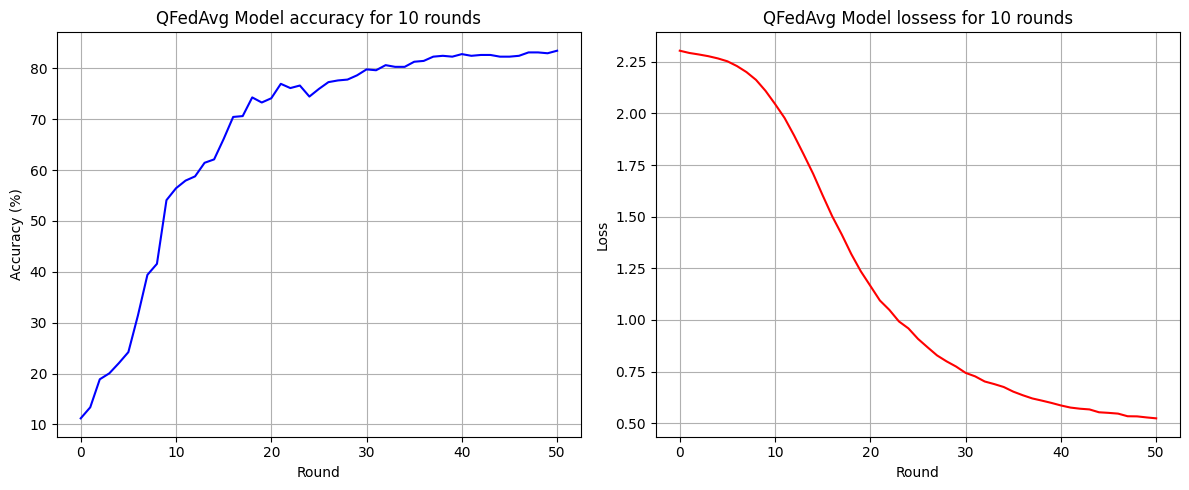

In [21]:
import matplotlib.pyplot as plt

print("Average Accuracy Variance: ", np.mean(np.array(accuray_var_list)))
print("Average Loss Variance: ", np.mean(np.array(loss_var_list)))
print()
# Extract accuracy and loss data
global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_loss_centralised = history.metrics_centralized["loss"]

# Plot accuracy
plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)
round_acc = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round_acc, acc, color='b')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("QFedAvg Model accuracy for 10 rounds")
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
round_loss = [data[0] for data in global_loss_centralised]
loss = [data[1] for data in global_loss_centralised]
plt.plot(round_loss, loss, color='r')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("QFedAvg Model lossess for 10 rounds")
plt.grid()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [7]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(
    number_of_examples=60000,
    batch_size=BATCH_SIZE,
    noise_multiplier=SGD_NOISE,
    num_epochs=EPOCHS,
    delta=1e-5,
)

'DP-SGD performed over 60000 examples with 8 examples per iteration, noise\nmultiplier 0.2 for 5 epochs with microbatching, and no bound on number of\nexamples per user.\n\nThis privacy guarantee protects the release of all model checkpoints in addition\nto the final model.\n\nExample-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with\nRDP accounting:\n    Epsilon with each example occurring once per epoch:       354.861\n    Epsilon assuming Poisson sampling (*):                   5037.128\n\nNo user-level privacy guarantee is possible without a bound on the number of\nexamples per user.\n\n(*) Poisson sampling is not usually done in training pipelines, but assuming\nthat the data was randomly shuffled, it is believed the actual epsilon should be\ncloser to this value than the conservative assumption of an arbitrary data\norder.\n'